# Проект: Продуктовая аналитика лендинга школы английского языка: A/B-тестирование

In [ ]:
# Подключаем библиотеки
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from scipy import stats
from statsmodels.stats.power import TTestIndPower
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd# **Проект:** "Предсказание стоимости домов для агентства недвижимости"

from google.colab import drive
drive.mount('/content/drive')

**Исходные данные:**<br>
 К нам обратился представитель крупного агентства недвижимости со
 следующей проблемой:<br>
 «Мои риелторы тратят катастрофически много времени на сортировку
 объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да
 и, сказать по правде, качество анализа не дотягивают до уровня конкурентов.
 Это сказывается на наших финансовых показателях.<br>
 Ваша задача - разработать модель, которая позволила бы обойти
 конкурентов по скорости и качеству совершения сделок.<br>

 **Цель проекта:** Разработать сервис для предсказания стоимости домов на основе истории предложений.<br>

 **Бизнес-задача:** Увеличить скорость и точность анализа объявлений риелторами, чтобы первыми находить выгодные сделки.<br>
  
  **Техническая задача:** Разработать модель машинного обучения, которая по набору характеристик дома будет предсказывать рыночную стоимость объекта недвижимости с приемлемой точностью.

## 1. Ознакомление с данными и первичный анализ

Начнём наше исследование со знакомства с предоставленными данными, но для начала импортируем модули, которые нам понадобятся для решения поставленной задачи.

Заранее импортируем модули, которые нам понадобятся для решения.

# Установим библиотеки:
!pip install dmba # для пошагового отбора признаков и AIC-критерия
!pip install catboost # градиентный бустинг от Яндекса
!pip install category_encoders # библиотека category_encoders при кодирвоании признаков
!pip install optuna #  для автоматического подбора гиперпараметров

# Подключаем библиотеки:
from google.colab import drive # подключение к Google диску
# Базовые библиотеки для работы с массивами и таблицами
import re
import numpy as np
import pandas as pd
# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# Работа с математикой, строками, датами и статистикой
import math
import ast
import os
import datetime
from scipy import stats
from scipy.stats import shapiro # тест Шапиро-Уилка
# Модули sklearn для предобработки данных, моделей и оценки
from sklearn import preprocessing # предобработка признаков
from sklearn import model_selection # разделение на выборки, кросс-валидация
from sklearn.model_selection import train_test_split # импортируем функцию train_test_split
from sklearn.linear_model import LinearRegression # для выполнения линейной регрессии
from sklearn.tree import DecisionTreeRegressor # для построения регрессионного дерева
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor # для ансамблевых методов регрессии
from catboost import CatBoostRegressor # для использования алгоритма градиентного бустинга с поддержкой категориальных признаков
from sklearn import metrics # метрики оценки моделей
from sklearn.metrics import r2_score, mean_squared_error # для оценки качества моделей
from sklearn import cluster # кластеризация
from sklearn import feature_selection # отбор признаков
from sklearn.preprocessing import OneHotEncoder, StandardScaler # кодирование категориальных признаков и масштабирования числовых
from sklearn.feature_selection import SelectKBest, f_regression # отбор лучших признаков по заданной метрике и импорт функции для оценки взаимосвязь признаков с целевой переменной
from sklearn.preprocessing import RobustScaler, LabelEncoder  # для масштабирования и кодирования категорий
import category_encoders as ce  # для бинарного кодирования категориальных переменных
# Импорт конкретных моделей, методов и модулей
from sklearn.linear_model import LinearRegression # линейная регрессия
from dmba import AIC_score, stepwise_selection # критерий AIC и пошаговый отбор (модуль dmba)
import pickle  # сохранение и загрузка объектов (моделей, данных и т.д)
import optuna  # библиотека для автоматической оптимизации гиперпараметров
import subprocess  # для запуска внешних процессов из Python (запуск скриптов)
import requests  # библиотека для отправки HTTP-запросов из Python
# Модели градиентного бустинга и ансамблей
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool

Прочитаем наш файл с исходными данными:

# Монтируем Google Диск
drive.mount('/content/drive')

# Загружаем данные
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/My_learning/data_main.csv')
# Выводим несколько первых строк датафрейма
display(df.head(2))
# Выводим несколько последних строк датафрейма
display(df.tail(2))

# Размерность датафрейма
df.shape

**Признаки:**
* status - статус продажи;
* private pool и PrivatePool - наличие собственного бассейна;
* propertyType - тип объекта недвижимости;
* street - адрес объекта;
* baths - количество ванных комнат;
* homeFacts - сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
* fireplace - наличие камина;
* city - город;
* schools - сведения о школах в районе (содержит несколько типов сведений);
* sqft - жилая площадь в кв. футах;
* zipcode - почтовый индекс;
* beds - количество спален;
* state - штат;
* stories - количество этажей;
* mls-id и MlsId - идентификатор MLS (Multiple Listing Service, система
мультилистинга);
* target - цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

# Выводим основную информацию о числе непустых значений в столбцах и их типах в датафрейме
df.info()

# Выполним проверку на наличие пропущенных значений NaN в датафрейме
df.isna().sum()

**Вывод:**<br>
1. Датафрейм содержит 377 185 объявлений о продаже недвижимости, каждое из которых описано с помощью 18 признаков;
2. Все признаки представлены типом object, в том числе целевой;
3. Присутсвуют пропуски в большинстве признаков.
4. В двух признаках 'homeFacts' и 'schools' содержатся дополнительные сведения, которые необходимо выделить в отдельные признаки.<br>

Таким образом, следующим этапом обработки данных будет этап: Предобработка данных и их подготовка к разведавательному анализу данных (EDA).<br>



## 2. Предобработка данных


В рамках предобработки данных выполняются следующие мероприятия:
* очистка данных от аномальных значений (выбросов);
* работа с пропущенными значениями;
* поиск и удаление дубликатов;
* приведение данных к необходимому для анализа формату;
* удаление признаков, которые не несут полезной информации;
* создание новых признаков (если присутствует необходимость).


### **2.1.** Начнем с дубликатов в наших данных.

Найдем **полные дубликаты** в таблице с предложениями о продаже недвижимости и удалим их.

# Найдем полные дубликаты
duplicates = df[df.duplicated(subset=df.columns)]
print(f'Количество полных дубликатов в таблице с предложениями о продаже недвижимости: {duplicates.shape[0]}')

# Удалим полные дубликаты
df = df.drop_duplicates()
print(f'Размерность датафрейма после удаления полных дубликатов: {df.shape}')

### **2.2.** Извлечение скрытых признаков из 'homeFacts' и 'schools' для последующего анализа.

#### Вынесем скрытые признаки, содержащиеся в признаке **'homeFacts'** в отдельные столбцы.

# Выводим описательную статистику по столбцу 'homeFacts'
df['homeFacts'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'homeFacts'
missing_count = df.homeFacts.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'homeFacts'
top_values = df.homeFacts.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

# Преобразуем строки в словари
def parse_homefacts(val):
    try:
        return ast.literal_eval(val)
    except:
        return None

df['homeFacts'] = df['homeFacts'].apply(parse_homefacts)

# Удалим строки с "пустыми" homeFacts, если все factValue пустые или None
def is_homefacts_empty(parsed_list):
    if isinstance(parsed_list, dict):
        parsed_list = parsed_list.get('atAGlanceFacts', [])
    return all(fact.get('factValue') in [None, '', '—'] for fact in parsed_list)

df = df[~df['homeFacts'].apply(is_homefacts_empty)].copy()

# Собираем все уникальные factLabel из 'homeFacts'
from collections import Counter # импортируем класс Counter для подсчёта частоты элементов

labels = []  # создаём пустой список для сбора всех factLabel

for row in df['homeFacts']:
    facts = row.get('atAGlanceFacts', []) if isinstance(row, dict) else []
    labels.extend([fact.get('factLabel') for fact in facts if fact.get('factLabel')])

# Выводим уникальные значения и их частоту
label_counts = Counter(labels)
print("Уникальные factLabel и их частота:")
for label, count in label_counts.most_common():
    print(f"{label}: {count}")

Выделим в отдельные признаки дополнительные сведения из столбца **'homeFacts'**, где:
* year built - год постройки;
* remodeled year - год реконструкции;
* heating - отопление;
* cooling - кондиционирование;
* parking - парковка;
* lotsize - площадь участка.

За исключением сведений 'price/sqft' (цена за квадратный фут), поскольку данный показатель напрямую связан с целевой переменной 'target' и может вызвать утечку данных при обучении модели. В связи с этим, данный признак не будет использоваться при построении предсказательной модели.

# Создадим функцию для извлечения значения по ключу factLabel
def extract_fact(facts_list, label):
    if isinstance(facts_list, dict):
        facts_list = facts_list.get('atAGlanceFacts', [])
    for fact in facts_list:
        if fact.get('factLabel') == label:
            return fact.get('factValue')
    return None

# Применяем функцию к нужным признакам
# Исключаем 'Price/sqft', чтобы избежать утечки целевой переменной
df['year_built'] = df['homeFacts'].apply(lambda x: extract_fact(x, 'Year built'))
df['remodeled_year'] = df['homeFacts'].apply(lambda x: extract_fact(x, 'Remodeled year'))
df['heating'] = df['homeFacts'].apply(lambda x: extract_fact(x, 'Heating'))
df['cooling'] = df['homeFacts'].apply(lambda x: extract_fact(x, 'Cooling'))
df['parking'] = df['homeFacts'].apply(lambda x: extract_fact(x, 'Parking'))
df['lotsize'] = df['homeFacts'].apply(lambda x: extract_fact(x, 'lotsize'))

# Удаляем исходный признак 'homeFacts', так как нужные данные уже извлечены
df = df.drop(['homeFacts'], axis=1)

#### Вынесем скрытые признаки, содержащиеся в признаке **'schools'**, в отдельные столбцы.

# Выводим описательную статистику по столбцу 'schools'
df['schools'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'schools'
missing_count = df.schools.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'schools'
top_values = df.schools.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Как видно, признак 'schools' имеет аналогичную структуру с признаком 'homeFacts', содержащий вложенные словари и списки. Внутри списка представлены данные о школах, включающие следующие элементы:
* rating - рейтинг школы;
* data, содержащий дополнительные характеристики:
** Distance - расстояние до школы в милях;
** Grades - уровень образования (начальная, средняя, старшая школа);
** name - название школы.

В рамках текущей задачи нас интересуют только следующие признаки: 'rating' и 'Distance', остальные параметры учитывать не будем.

Сначала преобразуем строковое представление признака в словарь, после чего извлечём необходимые данные и на их основе сформируем два новых признака.

# Выводим строки с индексами 1 и 2
df.iloc[1:3]

# Извлекаем список рейтингов из первого элемента в признаке 'schools'
df['rating'] = df['schools'].apply(lambda x: ast.literal_eval(x)[0]['rating'])

# Извлекаем список дистанций до школ из словаря 'data' внутри первого элемента
df['distance'] = df['schools'].apply(lambda x: ast.literal_eval(x)[0]['data']['Distance'])

# Удаляем исходный признак 'schools', так как нужные данные уже извлечены
df = df.drop(['schools'], axis=1)

# Проверим результат после внесённых изменений
df.head()

### **2.3** Выполним предобработку каждого признака по отдельности.

В первую очередь начнем с целевого признака **target**, отражающего цену недвижимости.

#### **target (цена объекта недвижимости в $)**

# Выводим описательную статистику по столбцу 'target'
df['target'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'target'
missing_count = df.target.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'target'
top_values = df.target.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Признак представлен в строковом формате и содержит символ доллара. Для преобразования его в числовой тип создадим функцию get_numeric_target().

# Создаем функцию, которая очистит данные и приведёт их к числовому формату
def get_numeric_target(arg):

    """Функция принимает на вход целевой признак target и преобразовывает его в числовой формат.
    В случае пустого значения признака функция возвращает np.NaN"""

    arg = str(arg)
    number_list = re.findall('[0-9]+', arg)
    if number_list == []:
        return np.nan
    else:
        result = ''
        for i in number_list:
            result = result + i
        return float(result)

# Применим функцию к признаку
df['target'] = df['target'].apply(lambda x: get_numeric_target(x))

# Так как число пропусков не велико,  заменим их медианным значением по столбцу
df['target'] = df['target'].fillna(df['target'].median())
print(f'Количество пропусков = {df["target"].isnull().sum()}.')

# Выводим описательную статистику по столбцу 'target'
df['target'].describe()

Как видно из описательной статистики для признака 'target' есть объекты недвижимости стоимостью 1 и 195 000 000 долларов, что явно являются выбросами. Средняя стоимость недвижимости составляет 618 476,7, что более чем вдвое превышает медиану и составляет 319 000. В качестве меры центральной тенденции будем использовать медиану, поскольку она устойчива к влиянию выбросов.

Также визуализируем распределение значений признака 'target'. Для этого создадим график распределения значений признака 'target'.

# Создаем график рассеяния распределения значений признака target
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.index, y=df['target'], color='blue')
plt.xlabel('Индекс')
plt.ylabel('Значение target')
plt.title('Распределение значений признака target')

Как результат график рассеяния значений признака 'target' подтвердил наличие выбросов.


Выполним очистку выбросов методом Тьюки (Tukey method), применив его не к исходному признаку target, а к его логарифмированной версии log_target.
Это позволит корректно обработать распределение с длинным правым хвостом, которое характерно для таких признаков, как цена, доход или площадь. Логарифмирование делает распределение более симметричным, благодаря чему границы выбросов, рассчитанные по методу Тьюки, становятся более адекватными.

# Удаляем явные выбросы
df = df[(df['target'] > 3) & (df['target'] < 1.95e8)]

# Создаем логарифмированную переменную
df['log_target'] = np.log1p(df['target'])

# Применяем метод Тьюки к логарифму
Q1 = df['log_target'].quantile(0.25)
Q3 = df['log_target'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем по границам IQR
df = df[(df['log_target'] >= lower_bound) & (df['log_target'] <= upper_bound)]

# Удаляем логарифмированный признак
df.drop(columns=['log_target'], inplace=True)

# Пересчитаем статистики
median_target = df['target'].median()
mean_target = df['target'].mean()

# Проверка результата
print(f'Оставшееся число строк: {df.shape[0]}')
print(f'Медиана цены: {median_target:.2f}')
print(f'Средняя цена: {mean_target:.2f}')
print(f'Отношение средняя/медиана: {mean_target / median_target:.2f}')


print(f'Число наблюдений после корректировки {df.shape[0]}.')
df['target'].describe()

**Вывод:<br>**
После очистки данных для признака 'target' число наблюдений уменьшилось до 338688, ушли аномальные значения в виде 1 или 195 млн.долларов, средняя цена стала больше медианной только в 1.4 раза.

#### **status (статус продажи)**

# Выводим описательную статистику по столбцу 'status'
df['status'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'status'
missing_count = df.status.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'status'
top_values = df.status.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Обработаем признак 'status' следующим образом:
1. Заменим пропуски на значение 'unknown';
2. Приведём все значения к одному регистру, чтобы значения статуса о продажи (например For sale и for sale стали одинаковыми.

# Заполняем пропуски в столбце 'status' значением 'unknown'
df['status'].fillna('unknown', inplace=True)
# Приводим все значения в столбце 'status' к нижнему регистру
df['status'] = df['status'].str.lower()

Отобразим все уникальные значения признака 'status'.

# Уникальные значения для признака 'status'
df['status'].unique().tolist()

# Количество уникальных значений признака 'status'
count_status = df['status'].nunique()
print("Количество уникальных значений признака 'status':", count_status)

 Так как обилие уникальных значений для признака 'status' (151 значение) затрудняет анализ, потому выполним нормализацию, объединив синонимы.

Итак, выполним объединение следующих значений статусов о продажи: <br>
* **active	(активен, в продаже)** -	active, a active, active option, active backup, active under contract, active contingency, active with contingencies,
active - auction, active with offer, active - contingent, active with contract,
temporary active;
* **for sale	(на продаже)** - for sale;
* **new construction	(новостройка)**	- new construction, new;
* **pending	(предложение принято)** -	pending, p, pending sale, p pending sale,
pending in, pending sh, pending inspection, pending continue to show, pending - continue to show, pending w/ cont., pending - taking backups, pending continue to show, pending - backup offer requested, pending bring backup, pending w/insp finance, pending offer approval, pending taking backups, pending take backups,
pending with contingencies, pending fe, pending ab;
* **contingent	(с условием)** -	contingent, contingent show,
contingent finance and inspection, contingent show, contingent no show, contingent release, contingent foreclosure, contingent - sale of home,
contingent take backup, contingent escape, contingent lien holder release,
contingency contract, contingency 48 hr (+/ ), conting accpt backups, ct,
ct insp - inspection contingency, c, contract contingent on buyer sale;
* **under contract	(под контрактом)**-  under contract, under contract show,
under contract   showing, under contract - show, u under contract, under contract backups, under contract - no show, under contract taking back up offers;
* **auction	(аукцион)** -	auction, / auction, pre-foreclosure / auction, auction - active;
* **foreclosure	(принудительная продажа)** - foreclosure, foreclosed, pre-foreclosure;
* **price change	(изменение цены)** -	price change;
* **back on market	(возвращено на рынок)** -	back on market;
* **backup (резерв/опция)** -	backup, backup contract, option contract, option pending, active backup, offer pending signature, accepted offer, pending w/backup wanted, pending backups wanted;
* **coming soon	(скоро на рынке)**-	все строки, начинающиеся на coming soon: с датой (например, coming soon: nov 21. и др.);
* **sold / closed	(продано)** -	sold: $285,000, sold: $15,000, closed, recently sold;
* **lease (аренда)**- lease/purchase, lease/purchase pending;
* **reactivated	(повторно активирован)** -	re activated, reactivated;
* **contract (контракт)**- contract, contract p;
* **unknown (нет данных)**-	unknown, ct, c, ps, pf, pi и любые другие однобуквенные обозначения или аббревиатуры;
* **other(другое)**-


#  Удаляем лишние пробелы в столбце 'status'
df['status'] = df['status'].str.strip()

# Создадим словарь группировки статусов
status_mapping = {
     # Активен (в продаже)
    'active': 'active',
    'a active': 'active',
    'active option': 'active',
    'active backup': 'active',
    'active under contract': 'active',
    'active contingency': 'active',
    'active with contingencies': 'active',
    'active - auction': 'active',
    'active with offer': 'active',
    'active - contingent': 'active',
    'active with contract': 'active',
    'temporary active': 'active',

     # На продаже
    'for sale': 'for sale',

     # Новостройка
    'new': 'new construction',
    'new construction': 'new construction',

     # Предложение принято
    'pending': 'pending',
    'p': 'pending',
    'pending sale': 'pending',
    'p pending sale': 'pending',
    'pending in': 'pending',
    'pending sh': 'pending',
    'pending inspection': 'pending',
    'pending continue to show': 'pending',
    'pending - continue to show': 'pending',
    'pending w/ cont.': 'pending',
    'pending - taking backups': 'pending',
    'pending, continue to show': 'pending',
    'pending - backup offer requested': 'pending',
    'pending bring backup': 'pending',
    'pending w/insp finance': 'pending',
    'pending offer approval': 'pending',
    'pending taking backups': 'pending',
    'pending take backups': 'pending',
    'pending with contingencies': 'pending',
    'pending fe': 'pending',
    'pending ab': 'pending',

     # С условием
    'contingent': 'contingent',
    'contingent show': 'contingent',
    'contingent finance and inspection': 'contingent',
    'contingent   show': 'contingent',
    'contingent   no show': 'contingent',
    'contingent   release': 'contingent',
    'contingent   foreclosure': 'contingent',
    'contingent - sale of home': 'contingent',
    'contingent take backup': 'contingent',
    'contingent escape': 'contingent',
    'contingent lien holder release': 'contingent',
    'contingency contract': 'contingent',
    'contingency 48 hr (+/ )': 'contingent',
    'conting accpt backups': 'contingent',
    'ct': 'contingent',
    'ct insp - inspection contingency': 'contingent',
    'c': 'contingent',
    'contract contingent on buyer sale': 'contingent',

     # Под контрактом
    'under contract': 'under contract',
    'under contract show': 'under contract',
    'under contract   showing': 'under contract',
    'under contract - show': 'under contract',
    'u under contract': 'under contract',
    'under contract backups': 'under contract',
    'under contract - no show': 'under contract',
    'under contract taking back up offers': 'under contract',

    # Аукцион
    'auction': 'auction',
    '/ auction': 'auction',
    'pre-foreclosure / auction': 'auction',
    'auction - active': 'auction',

     # Принудительная продажа
    'foreclosure': 'foreclosure',
    'foreclosed': 'foreclosure',
    'pre-foreclosure': 'foreclosure',

     # Изменение цены
     'price change': 'price change',

     # Возвращено на рынок
     'back on market': 'back on market',

     # Резерв
    'backup': 'backup',
    'backup contract': 'backup',
    'option contract': 'backup',
    'option pending': 'backup',
    'active backup': 'backup',
    'offer pending signature': 'backup',
    'accepted offer': 'backup',
    'pending w/backup wanted': 'backup',
    'pending backups wanted': 'backup',

    # Продано
    'closed': 'sold',
    'sold: $285,000': 'sold',
    'sold: $15,000': 'sold',
    'recently sold': 'sold',

     # Аренда
    'lease/purchase': 'lease',
    'lease/purchase pending': 'lease',

    # Повторно активирован
    're activated': 'reactivated',
    'reactivated': 'reactivated',

    # Контракт
    'contract': 'contract',
    'contract p': 'contract',

    # Нет данных
    'unknown': 'unknown',

     # Другое
    'accepting backups': 'other',
    'conditional contract': 'other',
    'listing extended': 'other',
}

# Также обрабатываем все coming soon (скоро на рынке) как одну группу
df['status'] = df['status'].apply(lambda x: 'coming soon' if str(x).startswith('coming soon') else x)

# Преобразуем значения признака 'status' по словарю status_mapping, если значение не найдено в словаре, то заменяем его на 'other'
df['status'] = df['status'].map(status_mapping).fillna('other')

Выведим уникальные значений для признака 'status' после группировки

# Количество уникальных значений для признаке 'status' после группировки
top_values = df['status'].value_counts()
print(f"Количество уникальных значений для признака 'status' после корректировки: {df['status'].nunique()}")
print('\nРаспределение значений:')
print(top_values)

Исключим объекты со статусом "lease" (аренда), так как это не продажа, а аренда. При прогнозе стоимости объекта недвижимости такие объекты ошибочно отображают цену как будто за продажу.

# Удаляем объекты со статусом "lease"
df = df[df['status'].str.lower() != 'lease']

Также визуализируем распределение значений признака 'status', для этого создадим график

# Строим гистограмму распределение объявлений по статусам
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='status', order=df['status'].value_counts().index, palette='viridis')

plt.xlabel('Статус объявления')
plt.ylabel('Количество объектов')
plt.title('Распределение объявлений по статусам')
plt.xticks(rotation=45)
plt.tight_layout()

# Добавим подписи над столбцами
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black', rotation=0)

plt.show()


# Выводим описательную статистику по столбцу 'status' после очистки данных
df['status'].describe()

**Вывод:**<br>
Таким образом, в результате очистки данных количество уникальных значений для признака 'status' составило 16 значений, вместо 156 значений.

#### **private pool и PrivatePool (наличие собственного бассейна)**


Оба признака 'private pool' и 'PrivatePool' отражают факт наличия собственного бассейна. Тем не менее, пока неясно, дублируют ли они друг друга полностью или содержат различную информацию.  Как следствие, необходимо провести сравнение и убедиться в их взаимосвязи.

# Выводим описательную статистику по столбцам 'private pool' и 'PrivatePool'
print("Статистика по 'private pool':")
print(df['private pool'].describe())

print("\nСтатистика по 'PrivatePool':")
print(df['PrivatePool'].describe())

for col in ['private pool', 'PrivatePool']:
    print(f"\nАнализ столбца '{col}':")

    # Подсчитываем количество пропущенных значений для столбцов 'private pool' и 'PrivatePool'
    missing_count = df[col].isnull().sum()
    print(f'Количество пропусков: {missing_count}')

    # Получаем 10 наиболее часто встречающихся значений для столбцов 'private pool' и 'PrivatePool'
    top_values = df[col].value_counts().nlargest(10)
    print('Топ-10 наиболее популярных значений:')
    print(top_values)

**Вывод:**<br>
Анализ показал, что признаки 'private pool' и 'PrivatePool' содержат более 70% пропущенных значений и не обладают достаточной информативностью для построения модели. В связи с этим данные признаки будут исключены из дальнейшего анализа.

# Удаляем неинформативные признаки 'private pool' и 'PrivatePool'
df = df.drop(['private pool', 'PrivatePool'], axis=1)

#### **propertyType (тип объекта недвижимости)**


# Выводим описательную статистику по столбцу 'propertyType'
df['propertyType'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'propertyType'
missing_count = df.propertyType.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'propertyType'
top_values = df.propertyType.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Приведем все записи к нижнему регистру, возможно количество уникальных значений сократится.

df['propertyType'] = df['propertyType'].str.lower()
print(f'Количество уникальных значений: {df.propertyType.nunique()}')

# Выводим уникальные значения признака 'propertyType' в порядке убывания
df['propertyType'].sort_values(ascending=False).unique().tolist()

Как видно, признак содержит множество уникальных значений, некоторые из которых состоят из составных описаний, разделённых запятой или символом. Для упрощения анализа выделим основную категорию, оставляя только первую часть каждого значения. После этого сгруппируем типы недвижимости с помощью словаря в более общие категории.

# Оставляем только первую часть строки до запятой, чтобы сократить количество уникальных значений
df['propertyType'] = df['propertyType'].str.split(',').str[0]
# Далее оставляем только первую часть строки до символа '/', чтобы унифицировать написание типов
df['propertyType'] = df['propertyType'].str.split('/').str[0]
# Выводим количество уникальных значений после обработки
print('Число уникальных значений:', df['propertyType'].nunique())
# Выводим уникальные значения
df['propertyType'].unique()

# Создадим словарь для группировки значений признака 'propertyType' в обобщённые категории
propertytype_dict = {
    'single_family_home': [
        'single family','single family home', 'single-family home', '1 story', '2 story', 'detached', '1 story',
        '1 story traditional', 'single detached', 'singlefamilyresidence', 'single wide',
        'single-wide mobile with land', 'two story', 'one story', 'one level unit', 'rancher',
        '1 1', 'single wide mh', 'one story traditional'
    ],
    'multi_family_home': [
        'multi-family', 'multi-family home', 'duplex', 'triplex', 'attached duplex', 'fourplex',
        'multi_level', 'multi family', '2 unit condo', '2-story'
    ],
    'condo': [
        'condo', 'coop', 'cooperative', 'condominium', 'apartment', 'co-op', '2 story condo', 'high rise'
    ],
    'townhouse': [
        'townhouse', 'townhome style', 'townhouse-interior', 'townhouse-end unit'
    ],
    'apartment': [
        'apartment', 'condominium (single level)', 'high-rise', 'mid-rise', 'low-rise (1-3 stories)', 'Flats', 'studio'
    ],
    'land': [
        'lot', 'land'
    ],
    'mobile_home': [
        'mobile/manufactured', 'manufactured house', 'mfd', 'mobile home', 'manufactured home',
        'manufactured double-wide', 'manufactured single-wide', 'mobile home 1 story', 'mobile manu - double wide'
    ],
    'miscellaneous': [
        'miscellaneous'
    ],
    'ranch': [
        'ranch', 'one story', 'high ranch', 'hi ranch'
    ],
    'modern': [
        'contemporary', "modern", 'mid-century modern', 'mountain contemporary', 'urban contemporary',
        'modern farmhouse', 'modernist', 'new build 2019'
    ],
    'historical': [
        'historical', 'designated historical home', 'historic vintage', 'old style', 'historic'
    ],
    'coastal': [
        'coastal', 'coastal contemporary', 'coastal ii', 'coastal modern', 'coastal two story'
    ],
    'other': [
        'Other', 'english', 'other style', 'florida', 'farms', 'carriage house', 'country english',
        'straight thru', 'less than 4 floors', 'bungalow', 'custom', 'arts & crafts', 'tudor',
        'split foyer', 'cottage', 'garden home', 'farm', 'farm house',  'farmhouse', 'houseboat',
        'ground floor', 'victorian', '3 story', '3+ stories', 'santa barbara',  'modular',
        'post and beam', 'manuf', 'multiple occupancy', 'attached', 'hawaiian plantation',
        'forest garden home', 'split-entry', 'texas hill country', 'lake house',
        '1 story with basement', 'hi-rise', 'coastal beach home',  'key west', 'loft',
        'english manor', 'mid-rise (4-7 stories)', 'mid-level', 'new englander',
        'residential (<1 acre)', 'residential (1+ acre)', 'split', 'split level', 'split (4 level)',
        'split (5+ level)', 'urban', 'patio', 'patio home', 'penthouse', 'manor', 'victorian',
        'key west', 'end unit'
    ]
}


# Создадис функцию для переименования значения признака 'propertyType' в обобщённую категорию
def propertytype_rename(arg):
    """
    Функция принимает на вход значение из признака 'propertyType' и сопоставляет ему
    обобщённую категорию согласно словарю propertytype_dict.

    Если значение не найдено ни в одной из групп словаря, функция возвращает 'other'.
    Это позволяет избежать появления NaN и сохраняет целостность данных.
    """
    for key, value in propertytype_dict.items():
        if arg in value:
            return key
    return 'other'

# Применяем функцию ко всем значениям столбца 'propertyType'
df['propertyType'] = df['propertyType'].apply(propertytype_rename)


Проверим наличие пропусков в обновлённом признаке 'propertyType' и проанализируем, как теперь распределены его значения.

print(f'количество пропусков:{df.propertyType.isna().sum()}')

# Количество значений по каждой категории признака 'propertyType' после корректировки
top_values = df['propertyType'].value_counts()
print(f"Количество уникальных значений для признака 'propertyType' после корректировки: {df['propertyType'].nunique()}")
print('\nРаспределение значений:')
print(top_values)

Также визуализируем распределение значений признака 'propertyType', для этого создадим график

# Строим гистограмму распределения объявлений по типам недвижимости
plt.figure(figsize=(12, 6))

# Используем сортировку по убыванию количества объектов в каждой категории propertyType
ax = sns.countplot(
    data=df,
    x='propertyType',
    order=df['propertyType'].value_counts().index,
    palette='viridis'
)

plt.xlabel('Тип недвижимости')
plt.ylabel('Количество объектов')
plt.title('Распределение объявлений по типам недвижимости')
plt.xticks(rotation=45)
plt.tight_layout()

# Добавим подписи над столбцами
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black')

plt.show()

**Вывод:**<br>
В результате обработки признака 'propertyType' и приведения его к обобщённым категориям число уникальных значений уменьшилось с 1249 до 13, что значительно повысит интерпретируемость и упростит анализ.

#### **street (адрес объекта)**


# Выводим описательную статистику по столбцу 'street'
df['street'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'street'
missing_count = df.street.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'street'
top_values = df.street.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

print(f' Процент уникальных значений для признака street: {round(100 * df.street.nunique() / df.shape[0], 2)}%')

**Вывод:**<br>
Признак street содержит 89,24% уникальных значений, что делает его практически уникальным для каждой записи. Он не несёт полезной информации для модели и может вызвать переобучение. Поэтому его целесообразно удалить.

# Удаляем неинформативный признак 'street'
df = df.drop(['street'], axis=1)

#### **baths (количество ванных комнат)**

# Выводим описательную статистику по столбцу 'baths'
df['baths'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'baths'
missing_count = df.baths.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'baths'
top_values = df.baths.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Отобразим все уникальные значения признака 'baths'.

# Уникальные значения для признака 'baths'
df['baths'].unique().tolist()

Как видно, признак 'baths' представлен в строковом формате и содержит как текстовые, так и числовые значения, включая запятую вместо десятичной точки в значении.<br>
Обработаем признак следующим образом:
1. Удалим текстовые пометки (Bath, Baths, ba, Bathrooms и т.д), но перед удалением приведем значения к строковому типу и нижнему регистру;
2. Заменим запятые на точку в значение;
3. Игнорируем строки с форматами: '1 / 1 / 1', ‘sq. ft.’, ‘-- baths’, которые приводятся к NaN;
4. Преобразуем значения в числовой формат и округлим до ближайшего целого;
5. Пропущенные значения заполним медианой;
6. Очистим признак от выбросов.

Для начала проанализируем явный аномальный объект со значением количества ванных комнат '116/116/116'.

# Выводим строку с аномальным значением количества ванных комнат '116/116/116'
print(df[df['baths'].astype(str).str.contains('116', na=False)])

Исходя из полученных значений видим, что и значение площади объекта недвижимости в футах 'sqft' также аномально, следовательно удалим данную строку.

# Удалим аномальный объект
df= df[~((df['baths'] == '116'))]

Проведём очистку признака 'baths' в соответствии с выбранным планом.

# Приведем значения к строковому типу и нижнему регистру в признаке 'baths'
df['baths'] = df['baths'].astype(str).str.lower()

# Удаляем текстовые пометки (bath, baths, ba, bathrooms и т.д.)
df['baths'] = df['baths'].str.replace(r'baths?|ba|bathroom[s]?:?', '', regex=True)

# Заменяем запятые на точки
df['baths'] = df['baths'].str.replace(',', '.')

# Удаляем явно некорректные значения
invalid_values = ['sq. ft.', '-- baths', '—', '~', '0 / 0', '1 / 1 / 1', '1 / 1-0 / 1-0 / 1-0']
df['baths'] = df['baths'].apply(lambda x: None if x in invalid_values else x)

# Преобразуем значения в числовой формат, где некорректные значения станут NaN
df['baths'] = pd.to_numeric(df['baths'], errors='coerce')

# Заполняем пропущенные значения медианой
df['baths'].fillna(df['baths'].median(), inplace=True)

# Округляем до ближайшего целого и приводим к целочисленному типу
df['baths'] = df['baths'].round().astype(int)

# Проверим результат
print(df['baths'].describe())

# Количество уникальных значений для признаке 'baths' после корректировки
top_values = df['baths'].value_counts()
print(f"Количество уникальных значений для признака 'baths' после корректировки: {df['baths'].nunique()}")
print('\nРаспределение значений:')
print(top_values)

Также визуализируем распределение значений признака 'baths'. Для этого создадим график boxplot (Распределение количества ванных комнат).

# Создаем график распределения количества ванных комнат
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['baths'])
plt.title('Распределение количества ванных комнат')
plt.xlabel('Количество ванных комнат')
plt.show()

Для более точного анализа аномалий (выбросов) создаём сводную таблицу для каждого типа недвижимости и считаем количество объектов с разным числом ванных комнат ('baths').


pivot = df.pivot_table(index='propertyType', columns='baths', aggfunc='size', fill_value=0)
print(pivot)

В результате выполненной предобработки данных выявлены явные аномалии в данных:
1. Максимальное количество ванных комнат составлет 750 ванн, что очень маловероятно для жилой недвижимости;
2. Очень высокое стандартное отклонение (19.67) указывает на наличие нескольких экстремальных значений, которые искажают статистику;
3. Нулевые значения в данных. Нулевое значение признака допустимо только для объектов типа land (земельный участок), где отсутствие ванных комнат логично. Для остальных типов недвижимости, предназначенных для проживания, наличие нуля указывает на пропущенное или некорректное значение и требует обработки (заполнения);
4. Некорректное значение количества ванн для земельного участка, где значение должно быть равным нулю.

Данные выбросы могут негативно повлиять на обучение модели, поэтому выполним очистку выбросов по методу Тьюки и заполним медианой нулевые значения для типов объектов недвижимости, где 0 является явной ошибкой и отткорректируем для типа объекта недвижимости land количество ванных комнат.

# Выполняем очистку выбросов по методу Тьюки (Tukey method)
Q1 = df['baths'].quantile(0.25)
Q3 = df['baths'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаляем строки с количеством ванн вне границ IQR
df = df[(df['baths'] >= lower_bound) & (df['baths'] <= upper_bound)]

# Заполняем нулевые значений медианой по каждому типу недвижимости,
# исключая объекты типа 'land' (для которых 0 ванн допустимо)
# Найдём медиану по типу недвижимости для всех, кроме land
median_baths_by_type = df[df['propertyType'] != 'land'].groupby('propertyType')['baths'].median()

# Проходим по строкам и заменяем 0 на медиану по типу недвижимости, если не land
def fill_baths(row):
    if row['baths'] == 0 and row['propertyType'] != 'land':
        return median_baths_by_type.get(row['propertyType'], np.nan)
    return row['baths']

df['baths'] = df.apply(fill_baths, axis=1)

# Для объектов типа 'land' устанавливаем количество ванн строго равным 0
df.loc[df['propertyType'] == 'land', 'baths'] = 0

# Проверим результат
print(f"Оставшееся количество записей: {df.shape[0]}")
print(f"Уникальные значения количества ванн после обработки: {sorted(df['baths'].unique())}")


# Проверим полученные результаты после очистки от аномалий.
# Для этого создаём сводную таблицу для каждого типа недвижимости
# и считаем количество объектов с разным числом ванных комнат ('baths')
pivot = df.pivot_table(index='propertyType', columns='baths', aggfunc='size', fill_value=0)
print(pivot)

Визуализируем распределение значений признака 'baths' после очистки от аномальных значений.

# Создаём область для двух визуализаций рядом
plt.figure(figsize=(16, 6))

# Строим график распределения количества ванных комнат после удаления выбросов
plt.subplot(1, 2, 1)
sns.boxplot(x=df['baths'], palette='pastel')
plt.title('Распределение количества ванных комнат (после очистки)')
plt.xlabel('Количество ванных комнат')

# Строим график распределения количества объектов по числу ванных комнат
plt.subplot(1, 2, 2)
ax = sns.countplot(data=df, x='baths', order=sorted(df['baths'].unique()), palette='viridis')
plt.title('Распределение количества объектов по числу ванных комнат (после очистки)')
plt.xlabel('Количество ванных комнат')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)

# Добавление подписей над столбцами гистограммы
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, color='black')

plt.tight_layout()
plt.show()


**Вывод:**<br>
Таким образом, в результате очистки данных количество уникальных значений для признака 'baths' составило 5 значений, вместо 193 значений. Также были удалены выбросы с аномальными значениями количества ванных комнат.

#### **fireplace (наличие камина)**


# Выводим описательную статистику по столбцу 'fireplace'
df['fireplace'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'fireplace'
missing_count = df.fireplace.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'fireplace'
top_values = df.fireplace.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

print(f'Процент пропусков: {round(df.fireplace.isnull().sum()/df.fireplace.shape[0] * 100, 2)}%')

**Вывод:**<br>
Анализ показал, что признак 'fireplace' содержит более 70% пропущенных значений и не обладает достаточной информативностью для построения модели. В связи с этим данный признак будет исключен из дальнейшего анализа.

# Удаляем неинформативный признак 'fireplace'
df = df.drop(['fireplace'], axis=1)

####  **city (город)**


# Выводим описательную статистику по столбцу 'city'
df['city'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'city'
missing_count = df.city.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'city'
top_values = df.city.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

# Приводим все значения к строковому типу и сортируем
unique_cities = sorted(df['city'].dropna().astype(str).unique().tolist())
for city in unique_cities:
    print(city)

В данных встречаются различные варианты написания одного и того же города (например, 'New York City' и 'New York'). Для корректности анализа приведём их к единому наименованию.

# Приводим названия городов к единому формату:
# устраняем опечатки, сокращения и альтернативные наименования одного и того же города
df['city'] = df['city'].str.replace('New York City','New York', regex=True) \
.replace('North pt','North port', regex=True) \
.replace({'Allentown City':'Allentown'}) \
.replace({'Anderson Twp':'Anderson Township'}) \
.replace({'Asheville City':'Asheville'}) \
.replace({'Atlaanta':'Atlanta'}) \
.replace({'Bainbridge Is':'Bainbridge Island'}) \
.replace({'Bay Harbor Is':'Bay Harbor Islands'}) \
.replace({'Bedford Hts':'Bedford Heights'}) \
.replace({'Bee Caves':'Bee Cave'}) \
.replace({'Belllingham':'Bellingham'}) \
.replace({'Bonita Spgs':'Bonita Springs'}) \
.replace({'College Pt':'College Point'}) \
.replace({'Columbia Twp':'Columbia Township'}) \
.replace({'Commercecity':'Commerce City'}) \
.replace({'Doctor Philips':'Doctor Phillips'}) \
.replace({'Fairfield Twp.':'Fairfield Twp'}) \
.replace({'Federalheights':'Federal Heights'}) \
.replace({'Ft Lauderdale':'Fort Lauderdale'}) \
.replace({'Ft Worth':'Fort Worth'}) \
.replace({'Ft. Worth':'Fort Worth'}) \
.replace({'Herkimer Ny':'Herkimer'}) \
.replace({'Hide A Way Hills':'Hideaway Hills'}) \
.replace({'High Pt':'High Point'}) \
.replace({'Hollywood Pa':'Hollywood Park'}) \
.replace({'Jamaica Est':'Jamaica Estates'}) \
.replace({'Jc':'Johnson City'}) \
.replace({'Lehigh':'Lehigh Acres'}) \
.replace({'Los Feliz L':'Los Angeles'}) \
.replace({'St Albans City':'St. Albans City'}) \
.replace({'Poughkeepsie City':'Poughkeepsie'}) \
.replace({'P C Beach':'Panama City Beach'}) \
.replace({'Allentown City':'Allentown'})

print(f'Число уникальных значений: {df.city.nunique()}')

Приведём значения к нижнему регистру, чтобы избежать дубликатов из-за регистра.

df['city'] = df['city'].str.lower()

Рассмотрим случаи, где вместо названия города указаны прочерки '--'

df[df['city'] == '--']

Городов немного, поэтому заполним их самостоятельно.

Воспользуемся ресурсом https://www.unitedstateszipcodes.org/33185/ и восстановим город по индексу вручную

df.at[15234, 'city'] ='orlando'
df.at[128298,'city'] = 'orlando'
df.at[325918,'city'] = 'mcallen'

# Проверим, не осталось ли прочерков '--'
df[df['city'] == '--']

Перейдем к пропускам NaN

# Рассмотрим случаи, где в столбце 'city' указаны пропуски (NaN)
missing_city_count = df['city'].isnull().sum()
print(f"Количество пропусков в столбце 'city': {missing_city_count}")

# Выведем строки с пропущенными значениями в 'city'
print(df[df['city'].isnull()])

df.at[7830, 'city'] = 'reddick'
df.at[21529, 'city'] = 'morriston'
df.at[26467, 'city'] = 'laredo'
df.at[130563, 'city'] = 'washington'
df.at[170347, 'city'] = 'kissimmee'
df.at[171302, 'city'] = 'laredo'
df.at[221281, 'city'] = 'laredo'
df.at[221870, 'city'] = 'laredo'
df.at[270923, 'city'] = 'laredo'
df.at[277462, 'city'] = 'reddick'
df.at[278517, 'city'] = 'kissimmee'
df.at[282020, 'city'] = 'kissimmee'
df.at[304932, 'city'] = 'kissimmee'
df.at[309263, 'city'] = 'kissimmee'
df.at[312970, 'city'] = 'dunnellon'
df.at[342346, 'city'] = 'laredo'
df.at[346292, 'city'] = 'miami'
df.at[358935, 'city'] = 'kissimmee'
df.at[370080, 'city'] = 'houston'

# Выведем строки, в которых отсутствует значение
missing_count = df.city.isnull().sum()
print(f'Количество пропусков: {missing_count}')

print(f'Число уникальных значений после очистки данных: {df.city.nunique()}')

**Вывод:<br>**
После очистки данных для признака 'city' число городов уменьшилось с 1927  до 1791.

#### **sqft (жилая площадь в кв. футах)**

# Выводим описательную статистику по столбцу 'sqft'
df['sqft'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'sqft'
missing_count = df.sqft.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'sqft'
top_values = df.sqft.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

# Выведим уникальные значения для признака 'sqft'
df.sqft.unique().tolist()

Признак 'sqft' представлен в строковом формате и содержит как текстовые, так и чиловые значения, включая запятую вместо точки в значении площади.<br>
Обработаем признак следующим образом:
1. Удалим лишние слова ('sqft', 'Total interior livable area:').
2. Удалим запятые из числа, так например превращая число '1,234' в '1234';
3. Преобразуем значения в числовой формат;
4. Пропущенные значения заполним медианным значением;
5. Очистим признак от выбросов.

# Создаем функцию для обработки значений признака 'sqft'
def convert_sqft(value):

    # Проверяем, является ли значение пропущенным np.nan или строка равна '--',
    # либо первый элемент после удаления запятых и разбиения строки равен '--',
    # тогда в таких случаях считаем значение отсутствующим и возвращаем np.nan
    if value is np.nan or value == '--' or value.replace(',', '').split(' ')[0] == '--':
        return np.nan

    # Если значение начинается со слова 'total', то извлекаем предпоследнее число из строки и преобразуем его в float
    if value.replace(',', '').split(' ')[0].lower() == 'total':
        return float(value.replace(',', '').split(' ')[-2])

    # В остальных случаях берем первое число из строки и преобразуем в float
    else:
        return float(value.replace(',', '').split(' ')[0])

# Применяем функцию, заменяя строки числовыми значениями площади
df['sqft'] = df['sqft'].apply(convert_sqft)

# Заполняем пропущенные значения медианой
df['sqft'] = df['sqft'].fillna(df['sqft'].median())

Для более точного анализа аномалий (выбросов) проверим, какие типы недвижимости содержат нули в признаке 'sqft' (жилая площадь)


# Выводим количество объектов с нулевой площадью по каждому типу недвижимости
print(df[df['sqft'] == 0]['propertyType'].value_counts())

Как видно, для объектов с типом недвижимости land (земельный участок) нулевое значение жилой площади допустимо, поскольку такие объекты не предполагают наличия построек и для них основным параметром является площадь участка (lotsize). Однако для остальных типов недвижимости (single_family_home, condo, multi_family_home, mobile_home, other) значение жилой площади, равное нулю, является некорректным и требует корректировки.


# Выводим описательную статистику по столбцу 'sqft'
df['sqft'].describe()

Из описательной статистики для признака 'sqft' (жилая площадь) видно, что присутствуют объекты недвижимости площадью как 0 кв.футов, так и 456 602 500 кв.футов, что явно являются выбросами и требуют корректировки. Средняя площадь недвижимости составляет 4103,331 кв.футов, что более чем вдвое превышает медиану и составляет 1760 кв.футов. В качестве меры центральной тенденции будем использовать медиану, поскольку она устойчива к влиянию выбросов.

Также визуализируем распределение значений признака 'sqft', для этого создадим график распределения площади объектов недвижимости с логарифмическим масштабированием, т.к данные "вытянуты" и обычный boxplot становится неинформативным.

# Строим график распределения площади объектов недвижимости с логарифмическим масштабированием

# Преобразуем признак 'sqft' с помощью логарифма, чтобы уменьшить влияние экстремальных значений
# и добавляем 1 к значению, чтобы избежать ошибок при log(0)
df['log_sqft'] = np.log1p(df['sqft'])

# Создаём график boxplot для логарифмированного признака 'sqft'
plt.figure(figsize=(10, 4))
sns.boxplot(x='log_sqft', data=df, color='skyblue')
plt.title('Распределение логарифма площади объектов недвижимости (log(sqft + 1))', fontsize=14)
plt.xlabel('log(sqft + 1)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Удаляем временный логарифмированный столбец
df.drop(columns='log_sqft', inplace=True)

Как результат график распределения площади объектов недвижимости с логарифмическим масштабированием для признака 'sqft' также подтвердил наличие выбросов.

Очистку от аномальных значений (выбросов) для признака 'sqft' выполним следующим образом:
* Для объектов недвижимости, где по определению жилая площадь не может быть равна нулю (например, жилые дома, квартиры и т.д), заменим нулевые значения медианными значениями внутри каждой категории propertyType. Для объектов типа land (земельные участки), где отсутствие жилой площади допустимо, нулевые значения оставим без изменений;
* Выбросы удалим с использованием метода Тьюки (Tukey method), применив его не к исходному признаку sqft, а к его логарифмированной версии log_sqft.
Это позволит корректно обработать распределение с длинным правым хвостом, которое характерно для таких признаков, как площадь, цена или доход.Логарифмирование делает распределение более симметричным, благодаря чему границы выбросов, рассчитанные по методу Тьюки, становятся более адекватными.

# Заполняем нули медианой в 'sqft' для объектов, у которых по логике не может быть нуля
mask = (df['sqft'] == 0) & (df['propertyType'] != 'land')
median_sqft_by_type = df[df['sqft'] > 0].groupby('propertyType')['sqft'].median()

# Применяем заполнение медианой по типу недвижимости
for prop_type, median_val in median_sqft_by_type.items():
    df.loc[mask & (df['propertyType'] == prop_type), 'sqft'] = median_val

# Создаем логарифмированную переменную
df['log_sqft'] = np.log1p(df['sqft'])

# Применяем метод Тьюки к логарифму
Q1 = df['log_sqft'].quantile(0.25)
Q3 = df['log_sqft'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем по границам IQR
df = df[(df['log_sqft'] >= lower_bound) & (df['log_sqft'] <= upper_bound)]

# Удаляем вспомогательный логарифмированный признак
df.drop(columns=['log_sqft'], inplace=True)

# Пересчёт описательных статистик
median_sqft = df['sqft'].median()
mean_sqft = df['sqft'].mean()

# Проверка результата
print(f'Оставшееся число строк: {df.shape[0]}')
print(f'Медиана жилой площади: {median_sqft:.2f}')
print(f'Средняя жил. площадь: {mean_sqft:.2f}')
print(f'Отношение средняя/медиана: {mean_sqft / median_sqft:.2f}')

# Выводим описательную статистику по столбцу 'sqft' после очистки
df['sqft'].describe()

Визуализируем распределение объектов недвижимости по площади после удаления аномальных значений.

# Создаём область для двух визуализаций рядом
plt.figure(figsize=(14, 6))

# Строим график распределения объектов недвижимости  после удаления выбросов
plt.subplot(1, 2, 1)
sns.boxplot(x=df['sqft'])
plt.title('Распределение объектов недвижимости по площади (после очистки)')

# Строим график распределения количества объектов недвижимости по площади
plt.subplot(1, 2, 2)
sns.histplot(df['sqft'], bins=50, kde=True)
plt.title('Распределение количества объектов по площади (после очистки)')
plt.xlabel('sqft')
plt.ylabel('Количество объектов')

plt.tight_layout()
plt.show()

**Вывод:**<br>
Таким образом, после очистки данных для признака 'sqft' число наблюдений уменьшилось до 314182, ушли аномальные значения площади, средняя цена стала больше медианной только в 1.1 раза.

#### **zipcode (почтовый индекс)**


# Выводим описательную статистику по столбцу 'zipcode'
df['zipcode'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'zipcode'
missing_count = df.zipcode.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'zipcode'
top_values = df.zipcode.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(f'Примеры уникальных значений: {df.zipcode.sort_values().unique()[:10]}')
print(top_values)

Как видно, признак 'zipcode' (почтовый индекс) включает дополнительную четырёхзначную часть, отделённую дефисом. Проанализируем, сколько таких записей содержится в данных и что данное обозначение значит.


print('Число записей, имеющих четырехзначную приставку:', df[df.zipcode.str.contains('.*-.*',na=False, regex=True)]['zipcode'].shape[0])
df[df.zipcode.str.contains('.*-.*',na=False, regex=True)]['zipcode'].head(5)

Поиск показал, что 4-значная приставка уточняет зону доставки внутри 5-значного zip-кода (например, квартал, здание или крупный получатель). Это дополнительная информация, полезная для сортировки, поэтому оставим её.

Также в данных присутствуют объекты с индексоами '--', '0', '00000'. Посмотрим на них:

# Выведем строки с некорректными значениями zip-кода: прочерк, 0 или '00000'
df[(df['zipcode'] == '--') | (df['zipcode'] == '0') | (df['zipcode'] == '00000')]

Поскольку таких записей всего 3, удалим из датафрейма строки с некорректными значениями в столбце zipcode ('--', '0', '00000'), а затем подсчитаем количество уникальных почтовых индексов.

# Удаляем строки с некорректными значениями в 'zipcode' ('--', '0', '00000')
df = df.drop(df[(df['zipcode'] == '--') | (df['zipcode'] == '0') | (df['zipcode'] == '00000')].index)
# Считаем количество уникальных значений в 'zipcode' после очистки
df.zipcode.nunique()

**Вывод:**<br>
Таким образом, после удаления некорректных значений в признаке 'zipcode' данные стали чище, и теперь количество уникальных индексов отражает только верные значения.

#### **beds (количество спален)**

# Выводим описательную статистику по столбцу 'beds'
df['beds'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'beds'
missing_count = df.beds.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'beds'
top_values = df.beds.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Отобразим все уникальные значения признака 'beds'.

# Уникальные значения для признака 'beds'
df['beds'].unique().tolist()

Как видно, признак 'beds' представлен в строковом формате и содержит как текстовые, так и числовые значения, включая запятую вместо десятичной точки в значении.<br>
Обработаем признак следующим образом:
1. Удалим текстовые пометки (Beds, beds, Bd и т.д), но перед удалением приведем значения к строковому типу и нижнему регистру;
2. Выполним поиск и корректировку значений вида: '1 Bath, 2 Bedrooms' (где будем извлекать значение 2), при этом если шаблон не найден, то ищем первое числовое значение для значений вида: '3 Beds', '6 bd', но если числовое значение не найдено для таких типов значений: 'Baths', 'sqft', то значение NaN;
3. Заменим запятые на точку в значение;
4. Преобразуем значения в числовой формат и округлим до ближайшего целого;
5. Пропущенные значения заполним медианой;
6. Очистим признак от выбросов.

Проведём очистку признака 'beds' в соответствии с выбранным планом.

# Создадим функцию для очистки и извлечения количества спален
def clean_beds(val):
    if pd.isna(val):
        return np.nan

    # Приводим значение к строковому типу, удаляем пробелы и приводим к нижнему регистру
    val = str(val).strip().lower()

    # Ищем шаблон вида "2 bedrooms"
    match_bedroom = re.search(r'(\d+(?:\.\d+)?)\s+bedroom[s]?', val)
    if match_bedroom:
        return float(match_bedroom.group(1))

    # Ищем первое число в строке
    match_general = re.search(r'\d+(\.\d+)?', val)
    if match_general:
        return float(match_general.group())

    return np.nan

# Применим функцию очистки
df['beds'] = df['beds'].apply(clean_beds)

# Заполняем пропущенные значения медианой
df['beds'] = df['beds'].fillna(df['beds'].median())

# Округляем до ближайшего целого и приводим к целочисленному типу
df['beds'] = df['beds'].round().astype(int)

# Проверим результат
print(df['beds'].describe())

# Количество уникальных значений для признака 'beds' после корректировки
top_values = df['beds'].value_counts()
print(f"Количество уникальных значений для признака 'beds' после корректировки: {df['beds'].nunique()}")
print('\nРаспределение значений:')
print(top_values)

Также визуализируем распределение значений признака 'beds'. Для этого создадим график boxplot (Распределение количества спален).

# Создаем график распределения количества спален
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['baths'])
plt.title('Распределение количества спален')
plt.xlabel('Количество спален')
plt.show()

Для более точного анализа аномалий (выбросов) создаём сводную таблицу для каждого типа недвижимости и считаем количество объектов с разным числом спален ('beds').


pivot = df.pivot_table(index='propertyType', columns='beds', aggfunc='size', fill_value=0)
print(pivot)

В результате выполненной предобработки данных выявлены явные аномалии в данных:
1. Максимальное количество спален составлет 708 шт., что очень маловероятно для жилой недвижимости;
2. Большое стандартное отклонение (1.77) указывает о наличии экстремальных значений, которые искажают статистику;
3. Нулевые значения в данных. Нулевое значение признака допустимо только для объектов типа land (земельный участок), где отсутствие спален логично. Для остальных типов недвижимости, предназначенных для проживания, наличие нуля указывает на пропущенное или некорректное значение и требует обработки (заполнения);
4. Некорректное значение количества спален для земельного участка, где значение должно быть равным нулю.

Данные выбросы могут негативно повлиять на обучение модели, поэтому выполним очистку выбросов по методу Тьюки и заполним медианой нулевые значения для типов объектов недвижимости, где 0 является явной ошибкой и отткорректируем для типа объекта недвижимости land количество спален.

# Выполняем очистку выбросов по методу Тьюки (Tukey method)
Q1 = df['beds'].quantile(0.25)
Q3 = df['beds'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаляем строки с количеством ванн вне границ IQR
df = df[(df['beds'] >= lower_bound) & (df['beds'] <= upper_bound)]

# Заполняем нулевые значений медианой по каждому типу недвижимости,
# исключая объекты типа 'land' (для которых 0 ванн допустимо)
# Найдём медиану по типу недвижимости для всех, кроме land
median_baths_by_type = df[df['propertyType'] != 'land'].groupby('propertyType')['beds'].median()

# Проходим по строкам и заменяем 0 на медиану по типу недвижимости, если не land
def fill_baths(row):
    if row['beds'] == 0 and row['propertyType'] != 'land':
        return median_baths_by_type.get(row['propertyType'], np.nan)
    return row['beds']

df['beds'] = df.apply(fill_baths, axis=1)

# Для объектов типа 'land' устанавливаем количество ванн строго равным 0
df.loc[df['propertyType'] == 'land', 'beds'] = 0

# Проверим результат
print(f"Оставшееся количество записей: {df.shape[0]}")
print(f"Уникальные значения количества спален после обработки: {sorted(df['beds'].unique())}")


# Проверим полученные результаты после очистки от аномалий.
# Для этого создаём сводную таблицу для каждого типа недвижимости
# и считаем количество объектов с разным числом спален ('beds')
pivot = df.pivot_table(index='propertyType', columns='beds', aggfunc='size', fill_value=0)
print(pivot)

Визуализируем распределение значений признака 'beds' после очистки от аномальных значений.

# Создаём область для двух визуализаций рядом
plt.figure(figsize=(16, 6))

# Строим график распределения количества спален после удаления выбросов
plt.subplot(1, 2, 1)
sns.boxplot(x=df['beds'], palette='pastel')
plt.title('Распределение количества спален (после очистки)')
plt.xlabel('Количество спален')

# Строим график распределения количества объектов по числу ванных комнат
plt.subplot(1, 2, 2)
ax = sns.countplot(data=df, x='beds', order=sorted(df['beds'].unique()), palette='viridis')
plt.title('Распределение количества объектов по числу спален (после очистки)')
plt.xlabel('Количество спален')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)

# Добавление подписей над столбцами гистограммы
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, color='black')

plt.tight_layout()
plt.show()


**Вывод:**<br>
Таким образом, в результате очистки данных количество уникальных значений для признака 'beds' составило 5 значений, вместо 94 значений. Также были удалены выбросы с аномальными значениями количества спален.

#### **state (штат)**

# Выводим описательную статистику по столбцу 'state'
df['state'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'state'
missing_count = df.state.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'state'
top_values = df.state.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Визуализируем распределение объявлений по количеству ванных комнат для признака 'state', для этого создадим график

# Строим гистограмму распределения объявлений по штатам для признака 'state'
state_counts = df['state'].value_counts().sort_values(ascending=False)  # сортировка по убыванию

plt.figure(figsize=(14, 6))
ax = sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')

plt.xlabel('Наименование штата')
plt.ylabel('Количество объектов')
plt.title('Распределение объявлений по штатам')
plt.xticks(rotation=45)
plt.tight_layout()

# Добавим подписи над столбцами
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black')

plt.show()


**Вывод:**<br>
Признак демонстрирует полную заполненность, что исключает необходимость дополнительной обработки пропусков.

#### **stories (количество этажей)**


# Выводим описательную статистику по столбцу 'stories'
df['stories'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'stories'
missing_count = df.stories.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'stories'
top_values = df.stories.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Отобразим все уникальные значения признака 'stories'.

# Уникальные значения для признака 'stories'
df['stories'].unique().tolist()

Как видно, признак 'stories' представлен в строковом формате и содержит как текстовые, так и числовые значения, включая запятую вместо десятичной точки в значении.<br>
Обработаем признак следующим образом:
1. Удалим текстовые пометки, но перед удалением приведем значения к строковому типу и нижнему регистру;
2. Выполним поиск и корректировку значений вида: '2 Level, Site Built', 'Multi/Split', One, Two, Multi/Split' и т.д;
3. Заменим запятые на точку в значение;
4. Преобразуем значения в числовой формат и округлим до ближайшего целого;
5. Пропущенные значения заполним медианой;
6. Очистим признак от выбросов.

Проведём очистку признака 'stories' в соответствии с выбранным планом.

# Создадим функцию для очистки и извлечения количества этажей
def clean_stories(val):
    if pd.isna(val):
        return np.nan

    # Приводим значение к строковому типу, удаляем пробелы и приводим к нижнему регистру
    val = str(val).strip().lower()

    # Словарные соответствия для слов one, two и т.д.
    word_to_num = {
        'one': 1,
        'two': 2,
        'three': 3,
        'four': 4,
        'five': 5,
        'six': 6,
        'seven': 7,
        'eight': 8,
        'nine': 9,
        'ten': 10
    }

    # Поиск числового шаблона, включая десятичные значения
    match_num = re.search(r'(\d+(\.\d+)?)', val)
    if match_num:
        return float(match_num.group(1))

    # Поиск числа, записанного словами, используя словарь
    for word, num in word_to_num.items():
        if word in val:
            return float(num)

    # Специальные случаи: 'multi', 'split', 'ranch', 'condo' и т.д.- считаем как NaN
    keywords_nan = ['multi', 'split', 'ranch', 'condo', 'townhouse', 'manufactured', 'farm', 'acreage', 'commercial',
                    'loft', 'high-rise', 'mid-rise', 'duplex', 'triplex', 'fourplex', 'sixplex', 'apartment',
                    'mobile', 'cabin', 'bungalow', 'victorian', 'cape', 'colonial', 'craftsman', 'chalet', 'patio']
    if any(k in val for k in keywords_nan):
        return np.nan

    # Если ни одно из условий не подошло, возвращаем NaN
    return np.nan


# Применяем функцию очистки к столбцу 'stories'
df['stories'] = df['stories'].apply(clean_stories)

# Заполняем пропущенные значения медианой
df['stories'] = df['stories'].fillna(df['stories'].median())

# Округляем до ближайшего целого и приводим к целочисленному типу
df['stories'] = df['stories'].round().astype(int)

# Проверяем результат
print(df['stories'].describe())

# Количество уникальных значений для признака 'stories' после корректировки
top_values = df['stories'].value_counts()
print(f"Количество уникальных значений для признака 'stories' после корректировки: {df['stories'].nunique()}")
print('\nРаспределение значений:')
print(top_values)

Также визуализируем распределение значений признака 'stories' с помощью графика boxplot, чтобы оценить распределение количества этажей у объектов недвижимости.

# Создаем график распределения количества этажей у объектов недвижимости
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['stories'])
plt.title('Распределение количества этажей у объектов недвижимости')
plt.xlabel('Количество этажей')
plt.show()

Для более точного анализа выбросов создаём сводную таблицу, в которой отображается количество объектов недвижимости с разным числом этажей (stories) для каждого типа недвижимости.


pivot = df.pivot_table(index='propertyType', columns='stories', aggfunc='size', fill_value=0)
print(pivot)

В результате выполненной предобработки данных выявлены явные аномалии в данных:
1. Максимальное количество этажей составлет 1002, что очень маловероятно для жилой недвижимости;
2. Большое стандартное отклонение (2.63) указывает о наличии экстремальных значений, которые искажают статистику;
3. Нулевые значения в данных. Нулевое значение признака допустимо только для объектов типа land (земельный участок), где отсутствие этажей логично. Для остальных типов недвижимости, предназначенных для проживания, наличие нуля указывает на пропущенное или некорректное значение и требует обработки (заполнения);
4. Некорректное значение количества этажей для земельного участка, где значение должно быть равным нулю.

Данные выбросы могут негативно повлиять на обучение модели, поэтому выполним очистку выбросов по методу Тьюки и заполним медианой нулевые значения для типов объектов недвижимости, где 0 является явной ошибкой и отткорректируем для типа объекта недвижимости land количество этажей.

# Выполняем очистку выбросов по методу Тьюки (Tukey method)
Q1 = df['stories'].quantile(0.25)
Q3 = df['stories'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаляем строки с количеством этажей вне границ IQR
df = df[(df['stories'] >= lower_bound) & (df['stories'] <= upper_bound)]

# Заполняем нулевые значений медианой по каждому типу недвижимости,
# исключая объекты типа 'land' (для которых 0 этажей допустимо)
# Найдём медиану по типу недвижимости для всех, кроме land
median_baths_by_type = df[df['propertyType'] != 'land'].groupby('propertyType')['stories'].median()

# Проходим по строкам и заменяем 0 на медиану по типу недвижимости, если не land
def fill_baths(row):
    if row['stories'] == 0 and row['propertyType'] != 'land':
        return median_baths_by_type.get(row['propertyType'], np.nan)
    return row['stories']

df['stories'] = df.apply(fill_baths, axis=1)

# Для объектов типа 'land' устанавливаем количество этажей строго равным 0
df.loc[df['propertyType'] == 'land', 'stories'] = 0

# Проверим результат
print(f"Оставшееся количество записей: {df.shape[0]}")
print(f"Уникальные значения количества этажей после обработки: {sorted(df['stories'].unique())}")


# Проверим полученные результаты после очистки от аномалий.
# Для этого создаём сводную таблицу для каждого типа недвижимости
# и считаем количество объектов с разным числом этажей ('stories')
pivot = df.pivot_table(index='propertyType', columns='stories', aggfunc='size', fill_value=0)
print(pivot)

Визуализируем распределение значений признака 'stories' после очистки от аномальных значений.

# Создаём область для двух визуализаций рядом
plt.figure(figsize=(16, 6))

# Строим график распределения количества этажей у объектов недвижимости после удаления выбросов
plt.subplot(1, 2, 1)
sns.boxplot(x=df['stories'], palette='pastel')
plt.title('Распределение количества этажей у объектов недвижимости (после очистки)')
plt.xlabel('Количество этажей')

# Строим график распределения количества объектов недвижимости по числу этажей
plt.subplot(1, 2, 2)
ax = sns.countplot(data=df, x='stories', order=sorted(df['stories'].unique()), palette='viridis')
plt.title('Распределение количества объектов недвижимости по числу этажей (после очистки)')
plt.xlabel('Количество этажей')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)

# Добавление подписей над столбцами гистограммы
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, color='black')

plt.tight_layout()
plt.show()


**Вывод:**<br>
Таким образом, в результате очистки данных количество уникальных значений для признака 'stories' составило 4 значения, вместо 317 значений. Также были удалены выбросы с аномальными значениями количества этажей.

#### **mls-id и MlsId (идентификатор MLS, Multiple Listing Service, система мультилистинга)**

Признаки 'mls-id' и 'MlsId' - это уникальные идентификаторы из системы MLS (Multiple Listing Service). Тем не менее, пока неясно, являются ли эти признаки полными дубликатами или содержат различающуюся информацию. Как следствие, необходимо провести сравнение и убедиться в их взаимосвязи.

# Выводим описательную статистику по столбцам 'mls-id' и 'MlsId'
print("Статистика по 'mls-id':")
print(df['mls-id'].describe())

print("\nСтатистика по 'MlsId':")
print(df['MlsId'].describe())

for col in ['mls-id', 'MlsId']:
    print(f"\nАнализ столбца '{col}':")

    # Подсчитываем количество пропущенных значений для столбцов 'mls-id' и 'MlsId'
    missing_count = df[col].isnull().sum()
    print(f'Количество пропусков: {missing_count}')

    # Получаем 10 наиболее часто встречающихся значений для столбцов 'mls-id' и 'MlsId'
    top_values = df[col].value_counts().nlargest(10)
    print('Топ-10 наиболее популярных значений:')
    print(top_values)

**Вывод:**<br>
Анализ показал, что признаки 'mls-id' и 'MlsId' содержат уникальные идентификаторы объектов из системы MLS (Multiple Listing Service). Из-за высокой доли пропусков (свыше 70%) и отсутствия информативности для построения модели, данные признаки будут исключены из дальнейшего анализа.

# Удаляем неинформативные признаки 'mls-id' и 'MlsId'
df = df.drop(['mls-id', 'MlsId'], axis=1)

 #### **year_built (год постройки)**

# Выводим описательную статистику по столбцу 'year_built'
df['year_built'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'year_built'
missing_count = df.year_built.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'year_built'
top_values = df.year_built.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Отобразим все уникальные значения признака 'year_built'.

# Уникальные значения для признака 'year_built'
df['year_built'].unique().tolist()

Также визуализируем распределение значений признака 'year_built' с помощью графика boxplot, чтобы оценить распределение объектов недвижимости по году постройки.

# Создаем график распределение объектов недвижимости по году постройки
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['year_built'])

# Устанавливаем заголовок и подписи осей
plt.title('Распределение объектов недвижимости по году постройки', fontsize=14)
plt.xlabel('Год постройки')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Как видно, признак 'year_built' представлен в строковом формате и содержит как текстовые, так и числовые значения. Также в признаке присутствуют явные аномальные значения (выбросы) года постройки и требуют корректировки. <br>
Обработаем признак следующим образом:
1. Преобразуем значения в строки и удалим пробелы.
2. Заменим некорректные значения ('', 'No Data', None, '559990649990', '1', '1019', '1057', '1060' и т.д) на NaN.
3. Преобразуем значения в числовой формат;
4. Пропущенные значения заполним медианой;
5. Удаляем явные аномалии по диапазону (очень ранние или будущие даты);
6. Применяем метод Тьюки (IQR) для удаления статистических выбросов;
7. Создаем новый признак 'house_age' (возраст объекта недвижимости) на основе признака 'year_built', который позволит улучшить предсказания модели;
8. В завершение принимаем решение: удаляем исходный признак 'year_built' из модели или используем только производный признак 'house_age'.

Проведём очистку признака 'year_built' в соответствии с выбранным планом.

#  Приводим признак к строковому типу (на случай, если есть значения не строкового типа)
df['year_built'] = df['year_built'].astype(str)

# Заменяем явно некорректные значения на NaN
invalid_values = ['No Data', '', 'nan', 'None']
df['year_built'] = df['year_built'].replace(invalid_values, np.nan)

# Преобразуем значения в числовой формат
df['year_built'] = pd.to_numeric(df['year_built'], errors='coerce')

# Заполняем пропуски медианой
df['year_built'] = df['year_built'].fillna(df['year_built'].median())

# Удаляем явные аномалии по диапазону (очень ранние или будущие даты)
df = df[(df['year_built'] >= 1850) & (df['year_built'] <= 2024)]

# Применяем метод Тьюки (IQR) для удаления статистических выбросов
Q1 = df['year_built'].quantile(0.25)
Q3 = df['year_built'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['year_built'] >= lower_bound) & (df['year_built'] <= upper_bound)]

#  Преобразуем значение в целое число
df['year_built'] = df['year_built'].astype(int)

# Проверка результата
print(df['year_built'].describe())
print(f"Оставшееся количество записей: {df.shape[0]}")

# Количество уникальных значений для признака 'year_built' после корректировки
top_values = df['year_built'].value_counts()
print(f"Количество уникальных значений для признака 'year_built' после корректировки: {df['year_built'].nunique()}")
print('\nРаспределение значений:')
print(top_values)

Также визуализируем распределение значений признака 'year_built' после очистки данных.

# Создаём область для двух визуализаций рядом
plt.figure(figsize=(10, 4))

# Строим график распределения объектов недвижимости по году постройки (после очистки)
sns.boxplot(x=df['year_built'])
plt.title('Распределение объектов недвижимости по году постройки (после очистки)', fontsize=14)
plt.xlabel('Год постройки')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Строим график распределения количества объектов по году постройки (после очистки)
plt.figure(figsize=(14, 6))
sns.histplot(data=df, x='year_built', bins=60, kde=False, color='skyblue', edgecolor='black')
plt.title('Распределение количества объектов по году постройки (после очистки)', fontsize=14)
plt.xlabel('Год постройки')
plt.ylabel('Количество объектов')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Создадим дополнительный признак 'house_age' (возраст объекта недвижимости), который позволит  улучшить предсказания модели.

# Добавляем новый признак 'house_age', рассчитанный как разница между текущим годом и годом постройки
year_current = datetime.datetime.now().year
df['house_age'] = year_current - df['year_built']

# Проверим количество пропусков для признака 'house_age'
print(f"Количество пропусков: {df['house_age'].isna().sum()}")

# Посмотрим основные статистики для признака 'house_age'
print("\nСтатистики признака house_age:")
print(df['house_age'].describe())

Визуализируем распределение возраста объектов недвижимости для признака 'house_age'

# Строим гистограмму распределения возраста объектов недвижимости
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='house_age', bins=30, kde=True, color='skyblue')

plt.xlabel('Возраст недвижимости (лет)')
plt.ylabel('Количество объектов')
plt.title('Распределение возраста объектов недвижимости')
plt.grid(True)
plt.tight_layout()
plt.show()


**Вывод:**<br>
Таким образом, в результате очистки данных число уникальных значений признака 'year_built' уменьшилось с 220 до 129, так же были удалены объекты с аномальными годами постройки. Создан признак 'house_age' (возраст недвижимости), потенциально улучшающий точность модели. Признак 'year_built' будет исключён ввиду его полной линейной зависимости от 'house_age' в обратной пропорции, что могло бы вызвать мультиколлинеарность и переобучение в линейных моделях.

# Удаляем признак 'year_built' из датафрейма
df.drop(columns=['year_built'], inplace=True)

#### **remodeled_year (год реконструкции)**  

# Выводим описательную статистику по столбцу 'remodeled_year'
df['remodeled_year'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'remodeled_year'
missing_count = df.remodeled_year.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'remodeled_year'
top_values = df.remodeled_year.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

# Найдем процент пропущенных данных в признаке remodeled_year
print('Процент пропущенных данных в признаке remodeled_year:', round((df[df['remodeled_year'] ==''].shape[0] + df['remodeled_year'].isnull().sum()) / df.shape[0] * 100, 2))

Отобразим все уникальные значения признака 'remodeled_year'.

# Уникальные значения для признака 'remodeled_year'
df['remodeled_year'].unique().tolist()

Также визуализируем распределение значений признака 'remodeled_year' с помощью графика boxplot, чтобы оценить распределение объектов недвижимости по году реконструкции.

# Создаем график распределение объектов недвижимости по году реконструкции
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['remodeled_year'])

# Устанавливаем заголовок и подписи осей
plt.title('Распределение объектов недвижимости по году реконструкции', fontsize=14)
plt.xlabel('Год реконструкции')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Как видно, признак 'remodeled_year' представлен в строковом формате и содержит как текстовые, так и числовые значения. Также в признаке присутствуют явные аномальные значения (выбросы) года реконструкции и требуют корректировки. <br>
Обработаем признак следующим образом:
1. Преобразуем значения в строки и удалим пробелы;
2. Заменим некорректные значения на NaN;
3. Преобразуем значения в числовой формат;
4. Пропущенные значения заполним медианой;
5. Применяем метод Тьюки (IQR) для удаления статистических выбросов;
6. Создадим новые признаки на основе 'remodeled_year':
* 'was_remodeled': бинарный признак, показывающий, была ли реконструкция (1, если год реконструкции > года постройки; 0 не была или NaN).
* 'remodeled_age' (количество лет прошедших с реконструкции), т.е. разница между текущим годом и remodeled_year, если значение не NaN.
При этом, пропуски в новых признаках обрабатываем следующим образом:
**  для 'was_remodeled' заполняется 0 (не было реконструкции).
** 'remodeled_age' оставляем NaN, если реконструкция неизвестна.
7. В завершение принимаем решение: удаляем исходный признак 'remodeled_year' из модели или используем только производные признаки ('was_remodeled', 'remodeled_age').


Проведём очистку признака 'remodeled_year' в соответствии с выбранным планом.

# Приводим признак к строковому типу (на случай, если есть значения не строкового типа)
df['remodeled_year'] = df['remodeled_year'].astype(str)

# Заменяем явно некорректные значения на NaN
invalid_values = ['No Data', '', 'nan', 'None']
df['remodeled_year'] = df['remodeled_year'].replace(invalid_values, np.nan)

# Преобразуем значения признака 'remodeled_year' в числовой тип
df['remodeled_year'] = pd.to_numeric(df['remodeled_year'], errors='coerce')

# Текущий год
year_current = datetime.datetime.now().year

# Создаем признак 'was_remodeled' была ли реконструкция
df['was_remodeled'] = df['remodeled_year'].notna().astype(int)

# Создаем признак 'remodeled_age' количество лет прошедших с реконструкции
df['remodeled_age'] = year_current - df['remodeled_year']

# При условии, если реконструкции не было, заполним возрастом дома
df['remodeled_age'] = df['remodeled_age'].fillna(df['house_age'])

# Приведем к целочисленному типу
df['remodeled_age'] = df['remodeled_age'].round().astype(int)

# Сохраняем доочищенное значение для анализа
df['remodeled_age_before'] = df['remodeled_age']

# Сохраняем доочищенное значение для анализа
df['remodeled_age_before'] = df['remodeled_age']

# Применяем метод Тьюки (IQR) для удаления статистических выбросов
Q1 = df['remodeled_age'].quantile(0.25)
Q3 = df['remodeled_age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Заменяем выбросы на медиану
median_age = df.loc[(df['remodeled_age'] >= lower_bound) & (df['remodeled_age'] <= upper_bound), 'remodeled_age'].median()
df.loc[(df['remodeled_age'] < lower_bound) | (df['remodeled_age'] > upper_bound), 'remodeled_age'] = median_age

# Проверка результата
print(df[['remodeled_year', 'was_remodeled', 'remodeled_age']].head())
print(f"Оставшееся количество записей: {df.shape[0]}")

Выводим описательную статистику для признака 'remodeled_age' после очистки от выбросов

# Описательная статистика для нового признака 'remodeled_age' после очистки от выбросов
print(df['remodeled_age'].describe())

Также визуализируем распределение значений признака 'remodeled_age' до и после очистки данных.

# Создаём область для двух визуализаций рядом
plt.figure(figsize=(14, 5))

# До очистки
plt.subplot(1, 2, 1)
sns.histplot(df['remodeled_age_before'], bins=50, kde=False, color='salmon', edgecolor='black')
plt.title('Возраст домов после последней реконструкции (до очистки)', fontsize=12)
plt.xlabel('Возраст реконструкции')
plt.ylabel('Количество объектов')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# После очистки
plt.subplot(1, 2, 2)
sns.histplot(df['remodeled_age'], bins=50, kde=False, color='skyblue', edgecolor='black')
plt.title('Возраст домов после последней реконструкции (после очистки)', fontsize=12)
plt.xlabel('Возраст реконструкции')
plt.ylabel('Количество объектов')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Удаляем признак 'remodeled_age_before', т.к он нужен был только для графика, а потом не требуется

df.drop(columns=['remodeled_age_before'], inplace=True)

Визуализируем распределение нового признака 'was_remodeled' (была ли реконструкция).

# Создаем график распределение домов по признаку "была ли реконструкция"
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='was_remodeled', palette='pastel')

plt.xlabel('Была ли реконструкция')
plt.ylabel('Количество объектов')
plt.title('Распределение домов по признаку реконструкции')
plt.xticks([0, 1], ['Нет', 'Да'])

# Добавим подписи
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Принимаем решение удалить признак  'remodeled_year', заменив его на более информативные производные признаки: 'was_remodeled' и 'remodeled_age', которые более наглядно отражают факт и давность реконструкции объекта.

# Удаляем признак 'remodeled_year'
df = df.drop(columns=['remodeled_year'])

**Вывод:**<br>
Таким образом, после очистки признака 'remodeled_year' можно сделать вывод, что благодаря выделению новых признаков: наличия реконструкции (was_remodeled) и возраста с момента последней реконструкции (remodeled_age) удалось преобразовать исходные разрозненные и неполные данные в более информативные и удобные для модели показатели. При этом исходный признак содержал много пропусков и некорректных значений, поэтому его использование напрямую было бы неэффективным.

#### **heating (отопление)**          


# Выводим описательную статистику по столбцу 'heating'
df['heating'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'heating'
missing_count = df.heating.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'heating'
top_values = df.heating.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Отобразим все уникальные значения признака 'heating'.

# Уникальные значения для признака 'heating'
df['heating'].unique().tolist()

Как видно признак 'heating' представлен в строковом формате содержит множество значений: как числовых, так и описательных, среди которых встречаются этажность, типы строений и другие характеристики, не всегда связанные с отоплением. Следовательно сделаем данный признак бинарным (1- есть отопление, 0 - нет отопления), так как основной вопрос для модели: есть ли система отопления или нет, а не её конкретный тип.

Обработаем признак следующим образом:
1. Приведем значения к строковому типу, удалим лишние пробелы и приведем к нижнему регистру;
2. Создаем список ключевых слов для того, чтобы автоматически отфильтровать и исключить из признака 'heating' значения, которые не относятся к системе отопления;
3. Создаем бинарный признак.

# Приведение значений к строковому типу, удаление лишних пробелов и приведение к нижнему регистру
df['heating'] = df['heating'].astype(str).str.strip().str.lower()

# Создаем список ключевых слов для того, чтобы автоматически отфильтровать и исключить из признака 'heating' значения, которые не относятся к системе отопления
irrelevant_keywords = [
    'story', 'level', 'site', 'townhouse', 'tri', 'split', 'basement',
    'ranch', 'cottage', 'cape', 'modular', 'loft', 'chalet', 'farm',
    'duplex', 'triplex', 'fourplex', 'apartment', 'condo', 'multi', 'dwelling',
    'detached', 'unit', 'building', 'floor', 'home', 'structure', 'style',
    'high-rise', 'mid-rise', 'low-rise'
]

# Создаем бинарный признак
# 1 - если указано наличие отопления (и оно релевантно), 0 - если значение отсутствует или некорректно
df['heating'] = df['heating'].apply(
    lambda x: 0 if pd.isna(x) or x in ['nan', 'none', '0', '0.0'] or any(kw in x for kw in irrelevant_keywords) else 1
).astype(int)

# Проверим распределение значений после корректировки
print(df['heating'].value_counts())

Визуализируем распределение признака 'heating' (наличие отопления)

# Строим график распределения признака 'heating'
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='heating', palette='Set2')
plt.title('Распределение признака "heating" (наличие отопления)')
plt.xlabel('Наличие отопления (0 = нет, 1 = да)')
plt.ylabel('Количество объектов')

# Добавим подписи над столбцами
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Вывод:**<br>
Таким образом, в результате очистки признака 'heating' были удалены нерелевантные и шумовые значения (этажность, типы строений и т.д.) не всегда связанные с отоплением. Также признак был преобразован в бинарный формат, т.е. упростили признак до формы пригодной для машинного обучения.

#### **cooling (кондиционирование)**        


# Выводим описательную статистику по столбцу 'cooling'
df['cooling'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'cooling'
missing_count = df.cooling.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'cooling'
top_values = df.cooling.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Отобразим все уникальные значения признака 'cooling'.

# Уникальные значения для признака 'cooling'
df['cooling'].unique().tolist()

Как видно признак 'cooling'  представлен в строковом формате и содержит как числовые, так и текстовые значения, включая описания, не всегда напрямую связанные с системой кондиционирования, так например, упоминания отопления, окон или других характеристик. Следовательно сделаем данный признак бинарным (1 - есть кондиционирование, 0 - нет кондиционирования), так как основной вопрос для модели: есть ли система кондиционирования или нет, а не её конкретный тип.

Обработаем признак следующим образом:
1. Приведем значения к строковому типу, удалим лишние пробелы и приведем к нижнему регистру;
2. Создаем список слов указывающих на отсутствие кондиционирования;
3. Создание бинарного признака.

# Приводим значения к строковому типу, удаляем лишние пробелы и приводим к нижнему регистру
df['cooling'] = df['cooling'].astype(str).str.strip().str.lower()

# Создаем список ключевых слов, указывающих на отсутствие кондиционирования или некорректные (нерелевантные) значения
irrelevant_keywords = [
    'no', 'none', 'no data', 'nan', '0', 'heating', 'heat', 'hot water', 'gas', 'propane', 'boiler', 'baseboard',
    'steam', 'panel', 'floor furnace', 'radiator', 'tankless', 'wall heat', 'woodstove', 'oil', 'space heater',
    'air purifier', 'ventilation', 'exhaust fan', 'high efficiency', 'common', 'maintenance'
]

# Преобразуем в бинарный признак: 1 - есть кондиционирование, 0 - нет кондиционирования или некорректное (нерелевантное) значение
df['cooling'] = df['cooling'].apply(
    lambda x: 0 if pd.isna(x) or any(kw in x for kw in irrelevant_keywords) else 1
).astype(int)

Визуализируем распределение признака 'cooling' (наличие кондиционирования)

# Строим график распределения для признака 'cooling'
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='cooling', palette='Set2')
plt.title('Распределение признака "cooling" (наличие кондиционирования)')
plt.xlabel('Наличие кондиционирования (0 = нет, 1 = да)')
plt.ylabel('Количество объектов')

# Добавим подписи над столбцами
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Вывод:**<br>
Таким образом, в результате очистки признака 'cooling' были удалены нерелевантные и шумовые значения (горячее водоснабжение, отопительный прибор, очиститель воздуха и т.д.) не всегда связанные с кондиционированием. Также признак был преобразован в бинарный формат, т.е. упростили признак до формы пригодной для машинного обучения.

#### **parking (парковка)**       


# Выводим описательную статистику по столбцу 'parking'
df['parking'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'parking'
missing_count = df.parking.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'parking'
top_values = df.parking.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Отобразим все уникальные значения признака 'parking'.

# Уникальные значения для признака 'parking'
df['parking'].unique().tolist()

Как видно признак 'parking'  представлен в строковом формате и содержит как числовые, так и текстовые значения, включая описания, не всегда напрямую связанные с парковкой, так например, упоминания лодок, бассейнов или других характеристик. Следовательно сделаем данный признак бинарным (1 - есть парковка, 0 - нет парковка), так как основной вопрос для модели: есть ли парковка или нет, а не её конкретный тип.

Обработаем признак следующим образом:
1. Приведем значения к строковому типу, удалим лишние пробелы и приведем к нижнему регистру;
2. Создадим список слов указывающих на отсутствие парковки;
3. Создадим бинарный признак.

# Приведем значения к строковому типу, удалим лишние пробелы и приведем к нижнему регистру
df['parking'] = df['parking'].astype(str).str.strip().str.lower()

# Создаем список значений, указывающих на отсутствие парковки или некорректную (нерелевантную) информацию
no_parking_keywords = [
    '', 'none', 'no data', '0', 'parking type', 'parking yn', 'garage type',
    'association insurance', 'air conditioning', 'clubhouse', 'swim pool',
    'boat', 'pvt', 'drvwy', 'bsmt', 'aggre'
]

# Создаем функцию очистки и преобразования признака 'parking' в бинарный формат (0 - нет парковки, 1 - есть парковка)
def clean_parking(arg):
    if arg in no_parking_keywords:
        return 0
    return 1

# Применяем функцию к признаку
df['parking'] = df['parking'].apply(clean_parking)

Визуализируем распределение признака 'parking' (наличие парковки)

# Строим график распределения признака 'parking'
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='parking', palette='Set2')
plt.title('Распределение признака "parking" (наличие парковки)')
plt.xlabel('Наличие парковки (0 = нет, 1 = да')
plt.ylabel('Количество объектов')

# Добавим подписи над столбцами
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(df['parking'].value_counts())

**Вывод:**<br>
Таким образом, в результате очистки признака 'parking' были удалены нерелевантные и шумовые значения (упоминание лодок, бассейнов и т.д.) не всегда связанные с парковкой. Также признак был преобразован в бинарный формат, т.е. упростили признак до формы пригодной для машинного обучения.

#### **lotsize (площадь участка)**      


# Выводим описательную статистику по столбцу 'lotsize'
df['lotsize'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'lotsize'
missing_count = df.lotsize.isnull().sum()
# Получаем 10 наиболее часто встречающихся значений в столбце 'lotsize'
top_values = df.lotsize.value_counts().nlargest(10)
print(f'Количество пропусков: {missing_count}')
print('Топ-10 наиболее популярных значений:')
print(top_values)

Отобразим все уникальные значения для признака 'lotsize'

# Уникальные значения для признака 'lotsize'
df['lotsize'].unique().tolist()

Также стоит отметить, что для признака 'lotsize' есть свои особенности обработки, поскольку lotsize в недвижимости обозначает размер земельного участка, на котором расположен объект. То есть это площадь земли, принадлежащей недвижимости.

При этом данный показатель особенно важен:
* для домов и земельных участков (ключевой параметр);
* для квартир (condo) и многоквартирных домов этот показатель может отсутствовать или быть неактуальным, так как участок земли общий или отсутствует вовсе.

Cгруппируем данные по типу недвижимости (propertyType) и по значению "проблемного" lotsize ('—', 'No Data', '-- sqft lot') и подсчитаем количество таких записей для каждой группы.

# Создаем маску, которая отбирает строки, где lotsize содержит "проблемные" значения
mask = df['lotsize'].isin(['—', 'No Data', '-- sqft lot'])

# Фильтруем DataFrame, оставляя только столбцы 'lotsize' и 'propertyType' у отобранных строк
df_filtered = df.loc[mask, ['lotsize', 'propertyType']]

# Группируем данные по типу недвижимости и значению lotsize,
# затем считаем количество записей в каждой группе
grouped = df_filtered.groupby(['propertyType', 'lotsize']).size().reset_index(name='count')
print(grouped)

Как видно, признак 'lotsize'  представлен в строковом формате и содержит как текстовые, так и числовые значения, включая запятую вместо точки в значении площади, также данные представлены в разных единицах: acres и sqft. <br>

Обработаем признак учитывая особенности признака следующим образом:
1. Преобразуем значения в квадратные футы (sqft), так например:
* значения в акрах (acres) переводим в sqft (1 acre = 43560 sqft);
* значения с указанием sqft (с запятыми или без);
* чисто числовые значения (с запятыми или без);
* значения '—', 'no data', '-- sqft lot', 'none', пустые строки  считаем пропусками (NaN).
2. Заполненяем пропущенные значения:
* для типов недвижимости, где площадь участка важна (single_family_home, multi_family_home, ranch, townhouse)  заполняем пропуски медианой lotsize для каждого типа отдельно;
* для остальных типов недвижимости заполняем пропуски нулём, т.к. площадь участка либо не относится, либо не актуальна. За исключением объектов типа condo (кондоминиум, квартира в многоквартирном доме), так как площадь участка для данных объектов обычно не применяется;
* если остались пропуски заполняем общей медианой по всему столбцу.
3. Удаляем выбросы методом Тьюки на логарифмическом масштабе (применяем логарифм сдвинутый log1p(lotsize) для сглаживания распределения).

# Создаем функцию для преобразования значений lotsize в числовой формат
def convert_lotsize_to_sqft(value):
    if pd.isna(value): # если значение отсутствует, возвращаем NaN
        return np.nan
    value = str(value).strip().lower() # приводим значение к строке, убираем пробелы и делаем строчными буквами

    # Проверяем, не является ли значение "проблемным"
    if value in ['—', 'no data', '-- sqft lot', 'none', '']:
        return np.nan

    # Обрабатываем значения в акрах (acres)
    match_acres = re.match(r'([\d\.]+)\s*acres?', value)
    if match_acres:
        acres = float(match_acres.group(1))
        return round(acres * 43560)  # округляем до целого

    # Обрабатываем значения с указанием sqft, включая запятые
    match_sqft = re.match(r'([\d,\.]+)\s*sqft', value)
    if match_sqft:
        sqft_str = match_sqft.group(1).replace(',', '')
        try:
            return round(float(sqft_str))
        except:
            return np.nan

    # Обрабатываем просто числовые значения (без единиц), с возможными запятыми
    value_clean = value.replace(',', '')
    if re.fullmatch(r'[\d\.]+', value_clean):
        return round(float(value_clean))

    # Если ни одно условие не подошло, возвращаем NaN
    return np.nan

# Преобразуем колонку 'lotsize' с помощью функции и сразу перезаписываем её
df['lotsize'] = df['lotsize'].apply(convert_lotsize_to_sqft)

# Типы недвижимости, для которых наличие lotsize обязательно
required_lotsize_types = ['single_family_home', 'multi_family_home', 'ranch', 'townhouse']

# Заменяем ненулевые lotsize у condo на 0, т.к. площадь участка для таких типов объектов обычно не применяется
df.loc[(df['propertyType'] == 'condo') & (df['lotsize'] > 0), 'lotsize'] = 0

# Создаём маску для строк, где lotsize стал NaN после преобразования
mask_nan = df['lotsize'].isna()

# Для обязательных типов недвижимости заполняем пропуски медианой lotsize по соответствующему типу
for t in required_lotsize_types:
    median_val = df.loc[(df['propertyType'] == t) & (~mask_nan), 'lotsize'].median()  # Вычисляем медиану по типу
    mask_fill = (df['propertyType'] == t) & (df['lotsize'].isna())  # Находим пропуски для этого типа
    df.loc[mask_fill, 'lotsize'] = median_val  # Заполняем пропуски медианой

# Для остальных типов недвижимости, где lotsize отсутствует, заполняем пропуски нулём
mask_other = ~df['propertyType'].isin(required_lotsize_types) & (df['lotsize'].isna())
df.loc[mask_other, 'lotsize'] = 0

# Если после всех замен остались пропуски, заполняем их медианой по всему датафрейму
df['lotsize'].fillna(df['lotsize'].median(), inplace=True)

# Проверяем результат обработки, выводим первые 20 строк с 'propertyType' и 'lotsize'
print(df[['propertyType', 'lotsize']].head(20))
print("Количество строк после очистки:", df.shape[0])

# Выводим описательную статистику по столбцу 'lotsize' после предварительной корректировки
df['lotsize'].describe()

Из описательной статистики для признака 'lotsize' после предварительной корректировки видно, что присутствуют объекты недвижимости c площадью участка как 0 кв.футов, так и 2 147 480 000 кв.футов, что явно являются выбросами и требуют корректировки. Средняя площадь участков составляет 40734,49 кв.футов, что более чем в 6 раз превышает медиану и составляет 6600 кв.футов. Стандартное отклонение очень большое 4 044 531 кв.футов, что говорит о наличии экстремальных выбросов.



Очистку от аномальных значений (выбросов) для признака 'lotsize' выполним следующим образом:
1. Подготовим данные до очистки от выбросов, для этого отбираем только положительные значения lotsize для корректного логарифмирования (log1p);
2. Удалим строки с нулевыми и отрицательными значениями, где lotsize ≤ 0, чтобы избежать ошибок при логарифмировании;
3. Преобразуем признак lotsize в логарифмический масштаб. Применяем np.log1p(lotsize) для уменьшения скошенности распределения и смягчения влияния выбросов;
4. Определяем границы выбросов методом Тьюки (IQR). Вычисляем первый (Q1) и третий (Q3) квартили логарифмированного признака, находим интерквартильный размах IQR = Q3 - Q1 и определяем верхнюю границу: Q3 + 1.5 * IQR;
5. Преобразуем верхнюю границу обратно в исходный масштаб. Переводим верхнюю границу из логарифмического масштаба обратно в квадратные футы с помощью np.expm1().
6. Исключаем из датафрейма все строки с lotsize выше рассчитанной верхней границы;
8. Визуализируем распределение объектов недвижимости по площади участка до  и после удаления аномальных значений.

# Подготовим данные до очистки (только положительные значения)
log_before = np.log1p(df[df['lotsize'] > 0]['lotsize'])

# Очистка выбросов по Тьюки (на log1p)
# Убираем строки, где lotsize <= 0 (иначе log вызовет ошибку)
df = df[df['lotsize'] > 0].copy()

# Вычисляем log1p от lotsize
log_lotsize = np.log1p(df['lotsize'])

# Применяем метод Тьюки к логарифму
Q1 = log_lotsize.quantile(0.25)
Q3 = log_lotsize.quantile(0.75)
IQR = Q3 - Q1
upper_bound_log = Q3 + 1.5 * IQR

# Переводим верхнюю границу обратно в sqft
upper_bound = np.expm1(upper_bound_log)

# Удаляем выбросы из датафрейма
df = df[df['lotsize'] <= upper_bound].copy()

# Подготовим данные после очистки
log_after = np.log1p(df['lotsize'])

# Пересчёт описательных статистик
median_lotsize_sqft = df['lotsize'].median()
mean_lotsize_sqft = df['lotsize'].mean()

# Проверка результата
print(f'Оставшееся число строк: {df.shape[0]}')
print(f'Медиана площади участка: {median_lotsize_sqft:.2f}')
print(f'Среднее значение площади участка: {mean_lotsize_sqft:.2f}')
print(f'Отношение средняя/медиана: {mean_lotsize_sqft / median_lotsize_sqft:.2f}')

Выведим обновленную статистику для признака 'lotsize' после очистки от выбросов

print("\nОбновлённая статистика lotsize:")
print(df['lotsize'].describe())

Визуализируем распределение объектов недвижимости по площади участка 'lotsize' после удаления аномальных значений.

# Построим график распределения значений площади участков для объектов недвижимости до и после очистки данных
sns.set(style="whitegrid", palette="pastel") # настройка стиля

# Создаём датафрейм для визуализации
plot_df = pd.DataFrame({
    'До очистки': log_before,
    'После очистки': log_after
})

# Строим график
plt.figure(figsize=(14, 6))
ax = sns.boxplot(data=plot_df, orient='h', width=0.6)

plt.title('Распределение площади участков (log1p) объектов недвижимости до и после очистки', fontsize=16)
plt.xlabel('log1p(lotsize)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Создаем аннотацию
ax.annotate('<- выбросы до очистки', xy=(plot_df['До очистки'].quantile(0.95), 0),
            xytext=(plot_df['До очистки'].quantile(0.95) + 1, 0.1),
            arrowprops=dict(facecolor='red', arrowstyle='->'),
            fontsize=10, color='red')

plt.tight_layout()
plt.show()

**Вывод:**<br>
Таким образом, в результате очистки признака 'lotsize':
* все значения площади были приведены к единой единице измерения: квадратным футам (переведены из акров, где необходимо);
* значения были преобразованы в числовой формат, очищены от текстовых пометок, лишних символов и пропусков;
* число наблюдений уменьшилось до 201 417, при этом были удалены аномально большие значения, искажавшие статистику;
* средняя площадь после очистки превышает медианную только в 1,11 раза, что говорит о снижении влияния выбросов;
* распределение признака стало более нормальным и сбалансированным, следовательно признак lotsize теперь пригоден для использования в моделях машинного обучения.

#### **rating (рейтинг школы)**           


# Выводим описательную статистику по столбцу 'rating'
df['rating'].describe()

Оценим наличие пропущенных значений и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'rating'
missing_count = df['rating'].isnull().sum()
print(f'Количество пропусков: {missing_count}')

Отобразим первые 10 непустых значений для признака 'rating'.

# Выводим первые 10 непустых значений для признака 'rating'
print(df['rating'].dropna().head(10))

Как видно, признак 'rating' представлен в строковом формате и содержит списки рейтингов школ, которые могут быть пустыми или включать обозначения отсутствующих данных, такие как 'NR' (нет рейтинга) и 'NA'. Для упрощения анализа создадим новый признак: 'average_school_rating', отражающий среднее значение рейтингов школ в районе.<br>

Таким образом, обработаем признак следующим образом:
1. Извлечём числовую часть рейтинга из строкового значения;
2. Отфильтруем некорректные значения и оставим только рейтинги от 1 до 10;
3. Преобразуем корректные значения в числовой формат (float);
4. Вычислим средний рейтинг школ для каждой строки;
5. Пропущенные значения заполним средним значением по признаку;
6. Удалим исходный признак rating, так как он больше не нужен.

# Создаем функцию для обработки признака 'rating', который представлен в виде списка строковых рейтингов школ
def convert_rating(ratings_list):

    # Допустимые значения рейтингов: от '1' до '10'
    valid_ratings = []
    valid_values = {str(i) for i in range(1, 11)}  # множество для быстрого поиска

    # Если список пустой или равен None, возвращаем np.nan
    if not ratings_list:
        return np.nan

    for i in ratings_list:
        if isinstance(i, str):
            # Извлекаем значение до символа '/' и убираем пробелы
            rating_value = i.split('/')[0].strip()

            # Проверяем, что значение рейтинга валидно
            if rating_value in valid_values:
                valid_ratings.append(float(rating_value)) # преобразуем строку в число с плавающей точкой

    # Если не найдено ни одного корректного значения, то вернём np.nan
    if not valid_ratings:
        return np.nan

    # Возвращаем округлённое среднее значение рейтинга
    return round(np.mean(valid_ratings), 2)


# Применяем функцию к признаку 'rating' и создаём новый признак
df['average_school_rating'] = df['rating'].apply(convert_rating)

# Заполняем пропуски средним значением рейтинга
mean_rating = round(df['average_school_rating'].mean(), 2)
df['average_school_rating'] = df['average_school_rating'].fillna(mean_rating)

# Удаляем исходный признак 'rating', так как он преобразован
df = df.drop(columns=['rating'])

# Выводим уникальные значения и их частоту после очистки признака 'average_school_rating'
print(df['average_school_rating'].value_counts())

# Выведим описательную статистику для признака 'average_school_rating'
print(df['average_school_rating'].describe())

Визуализируем распределение признака 'average_school_rating' (средний рейтинг школ)

# Создаем график распределения среднего рейтинга школ (average_school_rating)
plt.figure(figsize=(10, 5))
sns.histplot(df['average_school_rating'], bins=10, kde=True, color='skyblue')
plt.title('Распределение среднего рейтинга школ (average_school_rating)')
plt.xlabel('Средний рейтинг школ')
plt.ylabel('Количество объектов')
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод:**<br>
Таким образом, в результате обработки признака 'rating', содержащего списки с рейтингами школ (включая пропуски, такие как 'NR' и 'NA'), был создан новый обобщённый признак 'average_school_rating', который представляет собой среднее значение рейтингов школ в соответствующем районе.

#### **distance (расстояние до школы в милях)**

Оценим наличие пропущенных значений в признаке 'distance' и рассмотрим структуру данных в этом признаке.

# Подсчитываем количество пропущенных значений в столбце 'distance'
missing_count = df['distance'].isnull().sum()
print(f'Количество пропусков: {missing_count}')

Отобразим первые 10 непустых значений для признака 'distance'.

# Выводим первые 10 непустых значений для признака 'distance'
print(df['distance'].dropna().head(10))

Как видно, признак 'distance' представлен в строковом формате и содержит список расстояний до ближайших школ. Значения расстояний до школ представлены очень разнородно, так например: строка с числом и единицей измерения расстояния в милях, строки с и/без пробелов между числом и единицией измерения расстояния в милях, пустые списки [], означающие отсутствие школ рядом.  
Для упрощения анализа создадим новые признаки на основе признака 'distance':
* 'average_school_distance' (среднее расстояние до школ);
* 'school_count_in_area' (количество школ в районе).

Таким образом, обработаем признак следующим образом:
1. Извлечём числовые значения расстояний до школ, удалив суффикс 'mi' и лишние символы;
2. Преобразуем извлечённые значения в числовой формат, пропуская некорректные записи;
3. Для каждой строки рассчитаем:
* среднее расстояние до школ (average_school_distance);
* количество школ поблизости (school_count_in_area);
4. Пропуски в average_school_distance заполним средним значением по столбцу;
5. Значения 0 в school_count_in_area (где школы не найдены) заменим на медиану по признаку;
6. Удалим исходный признак distance, так как он заменён на числовые переменные;
7. Выполним анализ и очистку новых признаков 'average_school_distance' и 'school_count_in_area' от выбросов.






# Создаем функцию для обработки признака 'distance', который представлен в виде списка расстояний до школ
def extract_school_distance_info(distance_list):

    # Инициализируем пустой список для хранения числовых значений расстояний
    distances = []

    # Проходим по каждому элементу в списке расстояний
    for item in distance_list:
        # Удаляем суффикс 'mi' и преобразуем строку в float
        try:
            distance_value = float(item.split('mi')[0])
            distances.append(distance_value)
        except (ValueError, IndexError):
            continue  # пропускаем некорректные значения

    # Если удалось извлечь хотя бы одно расстояние
    if distances:
        average_distance = round(np.mean(distances), 2)
        school_count = len(distances)
    else:
        average_distance = np.nan
        school_count = 0

    return [average_distance, school_count]

# Создаём новые признаки на основе списка расстояний до школ
df['average_school_distance'] = df['distance'].apply(lambda x: extract_school_distance_info(x)[0])
df['school_count_in_area'] = df['distance'].apply(lambda x: extract_school_distance_info(x)[1])

# Заполняем 0 в school_count_in_area медианным значением, если школы не найдены
median_school_count = df['school_count_in_area'].median()
df['school_count_in_area'] = df['school_count_in_area'].apply(lambda x: median_school_count if x == 0 else x)

# Заполняем пропущенные значения в признаке 'average_school_distance' средним значением
mean_school_distance = round(df['average_school_distance'].mean(), 2)
df['average_school_distance'] = df['average_school_distance'].fillna(mean_school_distance)

# Удаляем исходный признак 'distance'
df = df.drop(columns=['distance'])

Выведем статистические данные по новым признакам 'average_school_distance' и 'school_count_in_area'.  

# Статистика для признака 'average_school_distance'
print("Статистика для признака 'average_school_distance':")
print(df['average_school_distance'].describe())

# Статистика для признака 'school_count_in_area'
print("\nСтатистика по 'school_count_in_area':")
print(df['school_count_in_area'].describe())

Также визуализируем распределение новых признаков 'average_school_distance' и 'school_count_in_area'.

# Создаём область для двух визуализаций рядом
sns.set(style="whitegrid") # устанавливаем стиль
plt.figure(figsize=(16, 6))

# Строим график распределения среднего расстояния до школ
plt.subplot(1, 2, 1)
sns.boxplot(
    x=df['average_school_distance'],
    color='skyblue',
    width=0.5,
    fliersize=3  # размер выбросов
)
plt.title('Распределение среднего расстояния до школ', fontsize=14)
plt.xlabel('Среднее расстояние (в милях)', fontsize=12)
plt.xticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Строим график распределения количества школ поблизости
plt.subplot(1, 2, 2)
sns.boxplot(
    x=df['school_count_in_area'],
    color='lightgreen',
    width=0.5,
    fliersize=3
)
plt.title('Распределение количества школ поблизости', fontsize=14)
plt.xlabel('Количество школ', fontsize=12)
plt.xticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout() # оптимизируем отступы
plt.show()

Анализ распределения новых признаков:
* В признаке 'average_school_distance' наблюдается выраженная правосторонняя асимметрия. Среднее значение составляет 2.55 мили, тогда как медиана равна 1.67 мили, что указывает на наличие объектов с аномально большими расстояниями до ближайших школ. Особенно выбивается максимальное значение 1590, 83 мили, которое выглядит нереалистично и существенно искажает распределение.
Для корректной обработки длинного правого хвоста и удаления выбросов без потери структуры распределения будет применена очистка методом Тьюки на логарифмически преобразованных значениях (log1p);

* Распределение признака 'school_count_in_area' выглядит сбалансированным и устойчивым. Медианное значение 3 школы, среднее значение 4,26, что говорит о том, что большая часть объектов окружена 3–4 школами, в то время как высокие значения встречаются редко. Минимум 1 школа, максимум 65 школ, что может соответствовать густонаселённым городским районам. Поскольку 75% объектов имеют не более 4 школ рядом, и явных выбросов не наблюдается, признак может быть напрямую использован в моделях машинного обучения без дополнительной очистки.

# Выполняем очистку от выбросов для признака 'average_school_distance'

# Логарифмируем признак (log1p) для сглаживания распределения
log_dist = np.log1p(df['average_school_distance'])

# Вычисляем квартали и IQR
Q1 = log_dist.quantile(0.25)
Q3 = log_dist.quantile(0.75)
IQR = Q3 - Q1

# Вычисляем верхнюю границу для выбросов по методу Тьюки
upper_bound_log = Q3 + 1.5 * IQR

# Фильтруем исходный df (без создания нового)
df = df[log_dist <= upper_bound_log].copy()

Выполним финальную визуализацию новых признаков: 'average_school_distance' (после очистки от выбросов) и 'school_count_in_area'.

# Создаём область для двух графиков рядом
plt.figure(figsize=(14, 5))

# Строим график распределения среднего расстояния до школ после очистки данных
plt.subplot(1, 2, 1)
sns.histplot(df['average_school_distance'], bins=30, kde=True, color='skyblue')
plt.title('Распределение среднего расстояния до школ (после очистки)', fontsize=14)
plt.xlabel('Среднее расстояние до школ (в милях)', fontsize=12)
plt.ylabel('Количество объектов', fontsize=12)
plt.grid(True)

# Строим график распределения количества школ поблизости
plt.subplot(1, 2, 2)
sns.boxplot(
    x=df['school_count_in_area'],
    color='lightgreen',
    width=0.5,
    fliersize=3
)
plt.title('Распределение количества школ поблизости', fontsize=14)
plt.xlabel('Количество школ', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Вывод обновлённой статистики
print("Обновлённая статистика average_school_distance:")
print(df['average_school_distance'].describe())

print("\nСтатистика school_count_in_area:")
print(df['school_count_in_area'].describe())


**Вывод:**<br>
Таким образом, в результате очистки признака 'distance':
1. Создано два новых признака:
* average_school_distance - среднее расстояние до ближайших школ;
* school_count_in_area - количество школ рядом с объектом недвижимости.
2. Были обработаны пропущенные и некорректные значения, а также удалены выбросы в 'average_school_distance' с помощью метода Тьюки на логарифмированных данных. Благодаря этому распределение стало более симметричным и пригодным для моделирования. Признак 'school_count_in_area' изначально не содержал выраженных выбросов и был использован без дополнительной очистки.

#### **Вывод:**

Для начала выведем общую информацию о датафрейме после этапа предобработки данных.

df.info()

Таким образом, в результате проведённой предобработки данные были успешно очищены и структурированы для дальнейшего анализа и моделирования:
1. Итоговая размерность датафрейма составила: 193 932 строки и 20 признаков(исходно: 377 185 строк и 18 признаков). В процессе обработки удалены неинформативные и дублирующие столбцы, добавлены новые признаки, повышающие ценность данных (например, house_age, was_remodeled, remodeled_age и др.);
2. Пропущенные значения устранены, т.е. все признаки полностью очищены от NaN;
3. Корректные типы данных: числовые признаки приведены к типам float64 и int64, а категориальные сохранены в формате object.

# Сделаем копию датафрейма перед преобразованием признаков
df_original = df.copy()

# Сохраняем очищенные данные в файл
df_original.to_csv("df_cleaned.csv", index=False)

# Скачиваем на компьютер
from google.colab import files
files.download("df_cleaned.csv")

## 3. Разведывательный анализ данных (EDA)

В этой части проекта:
* Исследуем сформированный набор данных;
* Определим ключевые характеристики объектов недвижимости, которые влияют на их стоимость. Это позволит выдвинуть предварительные гипотезы и выявить наиболее значимые параметры для оценки цены;
* Дополним наш анализ визуализациями, иллюстрирующими исследование.


#### **Числовые признаки**

Рассчитаем описательные статистики для числовых признаков и проинтерпретируем результат.

 # Сводная статистика по датафрейму для числовых признаков
df.describe()

**Вывод:**<br>
В результате выполненной предобработки данных можно сделать следующие выводы для числовых признаков:
1. **Жилая площадь (sqft). <br>**
Средняя площадь составляет 2053 кв. футов, медиана 1860 кв. футов. Диапазон значений широкий от 516 до 5957 кв. футов;
2. **Количество ванных (bath) и спален (beds). <br>**
Большинство объектов имеют 2 ванны и 3 спальни. Максимум 4 ванны и 5 спален, что соответствует типичному жилью среднего и высокого сегмента;
3. **Число этажей (stories). <br>**
У большинства домов 1 этаж. Присутствуют и более высокие строения (до 3 этажей);
4. **Возраст дома (house_age).** <br>
Возраст зданий в среднем 45 лет;
5. **Реконструкции (was_remodeled, remodeled_age).** <br>
Около 42% объектов проходили реконструкцию. Средний возраст с последнего ремонта 39 лет, но у многих она не производилась вовсе;
6. **Инженерные системы (heating, cooling, parking).**<br>
Преобладает наличие отопления и кондиционирования (более 93% и 89% соответственно). Парковка есть примерно у 61% объектов;
7. **Площадь участка (lotsize).** <br>
Среднее значение 8945 кв. футов, но с разбросом до 38 882. Медианное значение 8015 кв. футов;
8. **Окружение школами.<br>**
* Средний рейтинг школ рядом 5 по шкале до 10;
* Среднее расстояние до ближайших школ 2.05 мили, что говорит о доступности образования;
* Среднее количество школ поблизости 4.2, максимум до 65 (что характерно для городских районов);
9. **Целевая переменная target** (ценв объекта недвижимости в $):
Средняя стоимость объекта 398 360 долларов, но встречаются дома стоимостью до 2.97 млн. Медианое значение составляет 301 900 долларов, что отражает правостороннюю асимметрию.

Визуализируем зависимости целевого признака **'target' (цена объекта недвижимости в $)** от количественных переменных. Сделаем промежуточные выводы.




Для визуализации зависимости целевого признака 'target' от количественных переменных будем использовать среднее значение цены, поскольку это помогает отследить общую тенденцию как в среднем изменяется цена недвижимости в зависимости от различных факторов.

##### **зависимость target от sqft (жилая площадь в кв. футах)**

# Строим график зависимости средней цены объекта недвижисоти от жилой площади,
# сгруппировав площадь по интервалам, чтобы график был читаемым

# Создаем временный признак 'sqft_bin' с разбивкой жилой площади на 50 интервалов для построения графика
df['sqft_bin'] = pd.cut(df['sqft'], bins=50)

# Группируем по интервалам площади и вычисляем среднюю цену
grouped_data = df.groupby('sqft_bin')['target'].mean().reset_index()

# Преобразуем интервалы в строки для оси X (чтобы лучше отображать)
grouped_data['sqft_bin_str'] = grouped_data['sqft_bin'].astype(str)

# Строим линейный график
fig = px.line(
    grouped_data,
    x='sqft_bin_str',
    y='target',
    title='Зависимость средней цены объекта недвижимости от жилой площади',
    labels={'sqft_bin_str': 'Диапазон площади (кв.футы)', 'target': 'Средняя цена ($)'}
)

# Повернем подписи по оси X для читаемости
fig.update_layout(
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()

# Удаляем вспомогательный признак, чтобы он не мешал дальнейшим вычислениям
df.drop(columns=['sqft_bin'], inplace=True)

**Вывод:**<br>
Между жилой площадью объекта недвижимости и его стоимостью прослеживается выраженная положительная зависимость: с увеличением площади растёт и цена.

##### **зависимость target от baths	(количество ванных комнат)**

# Группируем данные по количеству ванных комнат и вычисляем среднюю цену
grouped_data = df.groupby('baths')['target'].mean().reset_index()

# Создаем столбчатый график
fig = px.bar(
    grouped_data,
    x='baths',
    y='target',
    text_auto='.2s',
    labels={'baths': 'Количество ванных комнат', 'target': 'Средняя цена ($)'},
    title='Зависимость средней цены объекта недвижимости от количества ванных комнат'
)

# Центрируем заголовок
fig.update_layout(title={'x': 0.5})

fig.show()

**Вывод:**<br>
Между количеством ванных комнат для объекта недвижимости и его стоимостью прослеживается выраженная положительная зависимость: с увеличением ванных комнат растёт и цена.

#####  **зависимость target от beds (количество спален)**

# Группируем данные по количеству спален и вычисляем среднюю цену
grouped_data = df.groupby('beds')['target'].mean().reset_index()

# Создаем столбчатый график
fig = px.bar(
    grouped_data,
    x='beds',
    y='target',
    text_auto='.2s',
    labels={'beds': 'Количество спален', 'target': 'Средняя цена ($)'},
    title='Зависимость средней цены объекта недвижимости от количества спален'
)

# Центрируем заголовок
fig.update_layout(title={'x': 0.5})

fig.show()

**Вывод:**<br>
Между количеством спален для объекта недвижимости и его стоимостью прослеживается выраженная положительная зависимость: с увеличением спален растёт и цена.

##### **зависимость target от stories (количество этажей)**

# Группируем данные по количеству этажей для объектов недвижимости и вычисляем среднюю цену
grouped_data = df.groupby('stories')['target'].mean().reset_index()

# Создаем столбчатый график
fig = px.bar(
    grouped_data,
    x='stories',
    y='target',
    text_auto='.2s',
    labels={'stories': 'Количество этажей', 'target': 'Средняя цена ($)'},
    title='Зависимость средней цены объекта недвижимости от количества этажей'
)

# Центрируем заголовок
fig.update_layout(title={'x': 0.5})

fig.show()

**Вывод:**<br>
Между количеством этажей у объекта недвижимости и его стоимостью прослеживается выраженная положительная зависимость: с увеличением количества этажей растёт и цена.

#####  **зависимость target от house_age	(возраст постройки)**

# Группируем данные по возрасту дома и вычисляем среднюю цену
grouped_data = df.groupby('house_age')['target'].mean().reset_index()

# Строим линейный график
import plotly.express as px

fig = px.line(
    grouped_data,
    x='house_age',
    y='target',
    title='Зависимость средней цены объекта недвижимости от возраста дома',
    labels={'house_age': 'Возраст дома (лет)', 'target': 'Средняя цена ($)'}
)

# Центрируем заголовок
fig.update_layout(title={'x': 0.5})

fig.show()

**Вывод:**<br>
Между возрастом дома и его ценой наблюдается отрицательная зависимость: с увеличением возраста дома средняя стоимость недвижимости снижается. Это ожидаемо, т.к. старые дома могут требовать ремонта.

##### **зависимость target от remodeled_age (количество лет прошедших с реконструкции)**

# Группируем данные по количеству лет прошедших с момента реконструкции и вычисляем среднюю цену
grouped_data = df.groupby('remodeled_age')['target'].mean().reset_index()

# Строим линейный график
import plotly.express as px

fig = px.line(
    grouped_data,
    x='remodeled_age',
    y='target',
    title='Зависимость средней цены объекта недвижимости от количества лет прошедших с момента реконструкции',
    labels={'remodeled_age': 'Лет с момента реконструкции', 'target': 'Средняя цена ($)'}
)

# Центрируем заголовок
fig.update_layout(title={'x': 0.5})

fig.show()


**Вывод:**<br>
Между количеством лет, прошедших с момента реконструкции и стоимостью недвижимости прослеживается обратная зависимость: чем больше времени прошло после последнего ремонта, тем ниже средняя цена объекта. Это подтверждает, что обновлённые или недавно реконструированные дома обычно стоят дороже благодаря улучшенному состоянию.

##### **зависимость target от was_remodeled (была ли реконструкция)**

# Группируем данные по признаку была ли реконструкция и вычисляем среднюю цену
grouped_data = df.groupby('was_remodeled')['target'].mean().reset_index()

# Заменим 0 и 1 на понятные подписи
grouped_data['was_remodeled'] = grouped_data['was_remodeled'].map({0: 'Нет', 1: 'Да'})

# Строим столбчатый график
import plotly.express as px

fig = px.bar(
    grouped_data,
    x='was_remodeled',
    y='target',
    text_auto='.2s',
    labels={'was_remodeled': 'Была ли реконструкция', 'target': 'Средняя цена ($)'},
    title='Зависимость средней цены объекта недвижимости от факта наличия реконструкции'
)

# Центрируем заголовок
fig.update_layout(title={'x': 0.5})

fig.show()

**Вывод:**<br>
Недвижимость, которая подвергалась реконструкции, в среднем стоит значительно дороже, чем объекты без реконструкции. Это может быть связано с тем, что обновлённые дома выглядят более привлекательно для покупателей, соответствуют современным стандартам и не требуют дополнительных вложений на ремонт.

##### **зависимость target от lotsize (площадь участка)**

# Строим график зависимости средней цены объекта недвижисоти от площади участка,
# сгруппировав площадь по интервалам, чтобы график был читаемым

# Создаем временный признак 'lotsize_bin' с разбивкой площади участка на 50 интервалов для построения графика
df['lotsize_bin'] = pd.cut(df['lotsize'], bins=50)

# Группируем по интервалам и рассчитываем среднюю цену
grouped_data = df.groupby('lotsize_bin')['target'].mean().reset_index()
grouped_data['lotsize_bin_str'] = grouped_data['lotsize_bin'].astype(str)

# Строим график
fig = px.line(
    grouped_data,
    x='lotsize_bin_str',
    y='target',
    labels={'lotsize_bin_str': 'Диапазон площади участка (кв.футы)', 'target': 'Средняя цена ($)'},
    title='Зависимость средней цены объекта недвижимости от площади участка'
)

# Повернем подписи по оси X для читаемости
fig.update_layout(
    title={'x': 0.5},
    xaxis_tickangle=45
)

fig.show()

# Удаляем временный признак
df.drop(columns=['lotsize_bin'], inplace=True)

**Вывод:**<br>
Наблюдается умеренная положительная зависимость между площадью участка и стоимостью недвижимости: в среднем, чем больше размер участка, тем выше цена. Однако начиная с определённого порога рост цены замедляется, что может указывать на насыщение рынка, т.е. увеличение участка не всегда пропорционально увеличивает ценность объекта.

##### **зависимость target от average_school_rating (среднее значение рейтингов школ в районе)**

# Группируем данные по рейтингу школ и вычисляем среднюю цену
grouped_data = df.groupby('average_school_rating')['target'].mean().reset_index()

# Создаём столбчатый график
fig = px.bar(
    grouped_data,
    x='average_school_rating',
    y='target',
    text_auto='.2s',
    labels={
        'average_school_rating': 'Средний рейтинг школ в районе (балл)',
        'target': 'Средняя цена ($)'
    },
    title='Зависимость средней цены объекта недвижимости от рейтинга школ поблизости'
)

# Центрируем заголовок
fig.update_layout(title={'x': 0.5})
fig.show()

**Вывод:**<br>
Между рейтингом школ в районе и стоимостью недвижимости прослеживается положительная зависимость: чем выше средний рейтинг школ, тем выше цена объекта. Это объясняется тем, что качественные учебные заведения повышают привлекательность района для семей с детьми, что в свою очередь влияет на спрос и стоимость недвижимости.

#####  **зависимость target от average_school_distance (среднее расстояние до школ)**

# Группируем данные по расстоянию до школ и вычисляем среднюю цену
grouped_data = df.groupby('average_school_distance')['target'].mean().reset_index()

# Округлим расстояние до ближайших 0.1 миль для лучшей агрегации
grouped_data['rounded_distance'] = grouped_data['average_school_distance'].round(1)

# Повторно сгруппируем и пересчитаем среднюю цену
plot_data = grouped_data.groupby('rounded_distance')['target'].mean().reset_index()

# Строим график
fig = px.line(
    plot_data,
    x='rounded_distance',
    y='target',
    labels={
        'rounded_distance': 'Среднее расстояние до школ (мили)',
        'target': 'Средняя цена ($)'
    },
    title='Зависимость средней цены объекта недвижимости от расстояния до ближайших школ'
)

# Центрируем заголовок
fig.update_layout(title={'x': 0.5})
fig.show()

**Вывод:**<br>
Между средней удалённостью до школ и ценой недвижимости наблюдается отрицательная зависимость: чем ближе школы расположены к объекту, тем выше его стоимость. Это подтверждает тот факт, что близость к образовательным учреждениям является важным фактором при выборе жилья, особенно для семей с детьми. При этом после определённых порогов влияние расстояния на цену начинает снижаться.

##### **зависимость target от school_count_in_area (количество школ поблизости)**

# Группируем данные по количеству школ и вычисляем среднюю цену
grouped_data = df.groupby('school_count_in_area')['target'].mean().reset_index()

# Строим график
fig = px.bar(
    grouped_data,
    x='school_count_in_area',
    y='target',
    labels={
        'school_count_in_area': 'Количество школ рядом',
        'target': 'Средняя цена ($)'
    },
    title='Зависимость средней цены объекта недвижимости от количества школ поблизости'
)

# Центрируем заголовок
fig.update_layout(title={'x': 0.5})
fig.show()

**Вывод:**<br>
Наблюдается положительная зависимость между количеством школ рядом и ценой недвижимости: объекты с большим числом образовательных учреждений в районе, как правило, стоят дороже. Это может быть связано с тем, что районы с хорошо развитой инфраструктурой считаются более привлекательными для проживания, особенно для семей с детьми. Однако начиная с определённых уровней рост цен замедляется, что может свидетельствовать о насыщении эффекта.

##### **зависимость target от heating (отопление)**

# Группируем данные по наличию отопления и вычисляем среднюю цену
grouped_data = df.groupby('heating')['target'].mean().reset_index()

# Строим график
fig = px.bar(
    grouped_data,
    x='heating',
    y='target',
    labels={
        'heating': 'Наличие отопления (0 - нет, 1 - есть)',
        'target': 'Средняя цена ($)'
    },
    title='Зависимость средней цены объекта недвижимости от наличия отопления'
)

# Центрируем заголовок
fig.update_layout(title={'x': 0.5})
fig.show()

**Вывод:**<br>
Наличие отопления оказывает заметное влияние на стоимость недвижимости. Объекты с установленной системой отопления стоят в среднем существенно дороже по сравнению с теми, где отопление отсутствует.

##### **зависимость target от cooling (кондиционирование)**

# Группируем данные по наличию кондиционирования и вычисляем среднюю цену
grouped_data = df.groupby('cooling')['target'].mean().reset_index()

# Строим столбчатый график
fig = px.bar(
    grouped_data,
    x='cooling',
    y='target',
    labels={
        'cooling': 'Наличие кондиционирования (0 - нет, 1 - есть)',
        'target': 'Средняя цена ($)'
    },
    title='Зависимость средней цены объекта недвижимости от наличия кондиционирования'
)

# Центрируем заголовок
fig.update_layout(title={'x': 0.5})
fig.show()

**Вывод:**<br>
Несмотря на распространённое мнение о положительном влиянии кондиционирования на стоимость недвижимости, в данном случае наблюдается обратная тенденция: объекты без кондиционирования в среднем стоят дороже.
Это может быть связано с тем, что более дорогие дома находятся в районах с мягким климатом или используют другие системы охлаждения, не учтённые в данных.

##### **зависимость target от parking (парковка)**

# Группируем данные по признаку 'parking' и вычисляем среднюю цену
grouped_data = df.groupby('parking')['target'].mean().reset_index()

# Создаем столбчатый график
fig = px.bar(
    grouped_data,
    x='parking',
    y='target',
    text_auto='.2s',
    labels={'parking': 'Наличие парковки', 'target': 'Средняя цена ($)'},
    title='Зависимость средней цены объекта недвижимости от наличия парковки'
)

# Центрируем заголовок
fig.update_layout(title={'x': 0.5})

fig.show()

**Вывод:**<br>
Наличие парковки положительно влияет на стоимость недвижимости: объекты с парковкой имеют в среднем более высокую цену по сравнению с теми, где парковка отсутствует. Это связано с удобством для жильцов и дополнительной ценностью недвижимости.

#### **Категориальные признаки**

# Сводная статистика по датафрейму (за исключением числовых признаков)
df.describe(include='object')

**Вывод:**<br>
В результате выполненной предобработки данных можно сделать следующие выводы для категориальных признаков:
1. **Статус продажи (status).** <br>
Содержит 16 уникальных значений, где самое частое значение: for sale(продается). Количество объектов со статусом "for sale" - 118 056, то есть примерно 61% от всех данных. Следовательно, большинство объектов на продаже, остальные сняты с продажи, проданы или другие статусы;
2. **Тип недвижимости (propertyType).** <br>
Содержит 11 уникальных типов, где наиболее частый: single_family_home (отдельный дом). Таких домов 157 206, то есть более 80% от всех объектов.
Следовательно в представленной выборке данных сильно преобладают отдельные дома, остальные типы (кондо, таунхаусы и т.д.) встречаются реже;
3. **Город (city).** <br>
Содержит 1423 уникальных городов, то есть данные охватывают большое число населённых пунктов. Наиболее часто встречается город Houston (12 992 объекта, т.е. 6.7% от всей выборки).
4. **Почтовый индекс (zipcode).** <br>
Содержит 3867 уникальных индексов, что отражает географическое разнообразие объектов. Самый частый индекс: 78245 (1182 объекта).
5. **Штат (state).** <br>
Содержит 33 уникальных штата, где самый частый штат: TX (Техас), с 54 100 объектами (около 28% выборки). Следовательно, данные по недвижимости сильно смещены в сторону Техаса.

В результате анализа категориальных признаков следует учитывать выраженный дисбаланс по штатам и типам недвижимости. Кроме того, признаки city и zipcode содержат большое количество уникальных значений, что может затруднить дальнейшую работу с данными. Для упрощения анализа и построения моделей может потребоваться дополнительное преобразование данных.

# Строим графики для каждого категориального признака ('status', 'propertyType', 'city', 'zipcode', 'state')

# Создаем копию датафрейма, чтобы избежать изменения оригинальных данных
df = df.copy()

# Задаём список категориальных признаков для анализа
categorical_features = ['status', 'propertyType', 'city', 'zipcode', 'state']

# Для признаков с большим числом уникальных значений (city, zipcode)
# оставляем только топ-20 самых частых значений, остальные заменяем на 'Other'
for col in ['city', 'zipcode']:
    top_categories = df[col].value_counts().nlargest(20).index
    df[col] = df[col].where(df[col].isin(top_categories), 'Other')

# Создаем функцию для построения столбчатого графика:
# отображает среднее значение 'target' (стоимость) для каждой категории признака
def plot_mean_target_by_category(feature):

    # Группировка по категории и вычисление среднего значения target
    grouped = df.groupby(feature)['target'].mean().reset_index().sort_values(by='target', ascending=False)

    # Строим столбчатые диаграммы
    fig = px.bar(
        grouped,
        x=feature,
        y='target',
        text_auto='.2s',  # подписи на столбцах, округлённые
        title=f'Средняя стоимость объекта недвижимости по признаку "{feature}"',
        color='target'  # цвет зависит от значения target
    )
    fig.update_layout(
        xaxis_tickangle=-45,  # наклон подписей по оси X
        title_x=0.5           # центрируем заголовок
    )
    fig.show()

# Строим график для каждого категориального признака из списка
for feature in categorical_features:
    plot_mean_target_by_category(feature)

**Вывод:**<br>
Анализ категориальных признаков и их влияние на стоимость объектов недвижимости показал:
 1. **Статус продажи (status).** <br>

Объекты со статусом "for sale" демонстрируют более высокую среднюю стоимость по сравнению с проданными объектами "sold". Это может свидетельствовать о том, что более дорогая недвижимость дольше остаётся на рынке, ожидая своего покупателя. В то же время, категории объектов со статусами "foreclosure", "back on market" и "contingent" характеризуются значительно более низкой средней ценой. Это может быть связано:
* с проблемами или неопределённостью при продаже contingent (объект находится в ожидании завершения условий сделки);
* с возвращением на рынок после сорванной сделки (back on market),
* либо с вынужденной продажей через банк по заниженной цене (foreclosure).

Следовательно можно сделать вывод, что статус объекта оказывает существенное влияние на его рыночную стоимость.

 2. **Тип недвижимости (propertyType).** <br>

График зависимости средней цены объекта недвижимости от его типа показал, что различные типы недвижимости заметно отличаются по средней стоимости. Так например, объекты с типами "coastal (прибрежная недвижимость)" и "historical (историческая недвижимость)" демонстрируют наиболее высокие средние цены, что вероятно связано с их уникальностью, расположением (прибрежные районы) или архитектурной ценностью. В то же время, объекты с типами "ranch", "land" и "mobile_home" характеризуются значительно более низкой стоимостью:
* ranch - сельская недвижимость с участками под фермерство;
* land - пустые земельные участки без построек;
* mobile_home - дома на колесах, доступный и недорогой вариант жилья, часто размещаемый в парках или на съёмной земле.

Таким образом, тип недвижимости также оказывает существенное влияние на рыночную стоимость.

 3. **Город (city). <br>**

Средняя стоимость недвижимости значительно варьируется между городами. Так например в таких городах как: Los Angeles, Seattle, Miami наблюдаются самые высокие средние цены. В то время как Indianapolis, Ocala, Jacksonville средняя стоимость объекта недвижимости заметно ниже, что подчёркивает влияние региональных факторов и различий в уровне жизни.

Следовательно можно сделать вывод, что местоположение объекта недвижимости оказывает существенное влияние на его рыночную стоимость.

 4. **Почтовый индекс (zipcode). <br>**

Аналогично признаку city, средняя стоимость объектов недвижимости значительно варьируется в зависимости от почтового индекса. В ряде зон наблюдаются высокие средние цены (например, в городах Los Angeles, Seattle и Miami), что может быть связано с престижностью районов, близостью к деловым центрам или расположением в прибрежной зоне. В то же время, в других почтовых зонах стоимость существенно ниже (например, Indianapolis, Ocala и Jacksonville), что зачастую обусловлено менее развитой инфраструктурой или удалённостью от деловой и социальной активности.

Таким образом, почтовый индекс, отражающий локальные особенности и уровень привлекательности района, оказывает существенное влияние на рыночную стоимость недвижимости.

 5. **Штат (state). <br>**

Средняя стоимость недвижимости существенно различается в зависимости от штата.
Наиболее высокие цены наблюдаются в таких регионах, как Калифорния (CA), Округ Колумбия (DC) и Нью-Йорк (NY). Это экономически развитые и густонаселённые территории, где отмечается высокий спрос на жильё, что и объясняет рост средней стоимости недвижимости в этих штатах. В то же время, штаты Мичиган (MI), Мэн (ME) и Оклахома (OK) характеризуются более доступным рынком недвижимости, что может быть связано с меньшей плотностью населения, уровнем доходов и спросом.

Таким образом, ещё раз подтверждается, что географическое положение оказывает существенное влияние на уровень цен, и признак state (штат) является важным фактором при анализе стоимости недвижимости.

**Общий вывод:  <br>**
Анализ категориальных признаков показал, что все рассматриваемые категории оказывают значимое влияние на стоимость недвижимости.

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, необходимо выполнить несколько важных шагов:
1. Проверка данных на нормальность. Этот этап важен, так как мы собираемся применять статистические методы, основанные на предположении о нормальном распределении данных;
2. Кодирование категориальных признаков. Многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их исходном виде, поэтому их необходимо закодировать в числовой формат;
3. Отбор признаков. Нужно выбрать признаки, которые будут использоваться для обучения модели, основываясь на их значимости и влиянии на целевую переменную;
4. Масштабирование и трансформация признаков. Для улучшения сходимости моделей, основанных на численных методах, важно масштабировать и трансформировать некоторые признаки.

**Проверка данных на нормальность**

Проверим, распределены ли данные  признака 'target' нормально, проведя тест Шапиро-Уилка

# Строим график распределения целевого признака "target
plt.figure(figsize=(12, 5))
sns.histplot(df['target'], kde=True, bins=30, color='skyblue')
plt.title('Распределение целевого признака "target"')
plt.xlabel('target')
plt.ylabel('Частота')
plt.show()

# Проводим тест Шапиро-Уилка
stat, p = shapiro(df['target'])
print(f"\n Shapiro-Wilk Test:")
print(f"Статистика = {stat:.4f}, p-значение = {p:.4f}")
if p < 0.05:
    print("→ Распределение статистически не является нормальным (отвергаем H₀)")
else:
    print("→ Нет оснований отвергать нормальность (не отвергаем H₀)")


**Вывод:**<br>
По результатам теста Шапиро-Уилка (статистика = 0,7356, p-значение = 0,0000) мы отклоняем нулевую гипотезу H₀ о нормальности распределения.
Следовательно, целевая переменная 'target' не имеет нормального распределения, что является типичной ситуацией для цен на недвижимость, так как они, как правило, асимметричны и смещены вправо.

# Выведим общую информацио о датафрейме до обработки признаков
df.info()

**Кодирование признаков**

Числовые признаки (numerical_features) обычно не кодируют, а используют напрямую. Однако, для моделей чувствительных к масштабам входных данных  рекомендуется выполнить масштабирование таких признаков с использованием методов стандартизации (StandardScaler) или нормализации (MinMaxScaler).

Категориальные признаки (categorical features) не могут быть напрямую использованы большинством алгоритмов машинного обучения и требуют предварительного преобразования в числовой формат. В зависимости от количества уникальных значений и характера признака применяются различные методы кодирования, включая one-hot encoding, label encoding, frequency encoding, binaryEncoder и другие.

# Посмотрим количество уникальных значений в категориальных признаках
for col in categorical_features:
    print(f"{col}: {df[col].nunique()}")

Решение по кодированию и масштабированию признаков:
* для категориальных признаков ('status', 'propertyType', 'city', 'zipcode', 'state') выполним бинарное кодирование, т.к. во всех перечисленных признаках более 10 уникальных значений, а использование OneHot-кодирования привело бы к чрезмерному увеличению размерности данных;
* для числовых признаков ('baths', 'sqft', 'beds', 'stories', 'heating', 'cooling', 'parking', 'lotsize', 'house_age', 'was_remodeled', 'remodeled_age', 'average_school_rating', 'average_school_distance', 'school_count_in_area') выполним масштабирование с помощью метода стандартизации RobustScaler, который устойчив к выбросам и позволяет сохранить информативность данных.

# Категориальные признаки для бинарного кодирования
categorycal_features = ['status', 'propertyType', 'city', 'zipcode', 'state']

# Применяем бинарное кодирование
bin_encoder = ce.BinaryEncoder(cols=categorycal_features)
df = bin_encoder.fit_transform(df)

# Числовые признаки
numerical_features = [
    'baths', 'sqft', 'beds', 'stories', 'heating', 'cooling',
    'parking', 'lotsize', 'house_age', 'was_remodeled', 'remodeled_age',
    'average_school_rating', 'average_school_distance', 'school_count_in_area'
]

# Масштабируем числовые признаки с использованием RobustScaler
scaler = RobustScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Выведем первые 5 строк датафрейма для проверки результатов кодирования и масштабирования
df.head()

# Выведим общую информацио о датафрейме после обработки признаков
df.info()

Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности

# Отбираем только числовые признаки из итогового датафрейма
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Вычисляем матрицу корреляции по числовым признакам
df_corr = df[numerical_columns].corr()

# Маска для фильтрации коэффициентов с модулем >= 0.9
mask = df_corr.abs() < 0.9
filtered_corr = df_corr.mask(mask)

# Увеличим размер фигуры для лучшей читаемости
plt.figure(figsize=(24, 20))

# Строим тепловую карту
sns.heatmap(
    filtered_corr,
    vmin=-1,
    vmax=1,
    linewidth=0.5,
    linecolor='gray',
    cmap='coolwarm_r',
    annot=True,
    fmt='.2f',
    square=False,
    cbar_kws={"shrink": 0.75},
    mask=filtered_corr.isnull(),
    annot_kws={"size": 11}
)

# Настроим подписи осей
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

plt.title('Мультиколлинеарность признаков (|корреляция| ≥ 0.9)', fontsize=20, pad=20)
plt.tight_layout()
plt.show()

**Вывод:**<br>
Как видно из графика,  признаки не имеют высокой взаимной корреляции, следовательно, мультиколлинеарность отсутствует.

Строи график корреляции признаков с целевым признаком 'target'

# Вычисляем корреляцию по числовым признакам
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df_corr = df[numerical_columns].corr()

# Убираем саму корреляцию 'target' с 'target'
plot_df = df_corr.drop(index='target')

# Ранжируем признаки по абсолютному значению корреляции
feature_order = plot_df['target'].abs().sort_values(ascending=False).index

# Создаем фигуру большого размера
plt.figure(figsize=(28, 12))

# Строим горизонтальный график для читаемости длинных названий
ax_bar = sns.barplot(
    data=plot_df.reset_index(),
    y='index',
    x='target',
    order=feature_order,
    palette='coolwarm'
)

# Подписи и оформление
ax_bar.set_yticklabels(ax_bar.get_yticklabels(), fontsize=12)
ax_bar.set(
    title="Корреляция признаков с целевым признаком 'target'",
    xlabel='Коэффициент корреляции Пирсона',
    ylabel='Признаки'
)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Вывод:** <br>
В результате проведённых преобразований и анализа признаков мультиколлинеарность в данных отсутствует. Ни одна пара признаков не демонстрирует корреляцию по модулю выше 0,9. Это свидетельствует о хорошей независимости признаков и снижает риск переобучения для моделей.

Кроме того, по итогам анализа корреляции с целевым признаком 'target' были выявлены признаки, наиболее с ней связанные, что может быть полезно для последующего отбора признаков и построения модели:

Признаки с наибольшей корреляцией с 'target':
* sqft (жилая площадь);
* average_school_rating (средний рейтинг школ в районе);
* baths (количество ванных комнат);
* beds (количество спален).

Формирование матрицы признаков и разбиение данных на train/test

# Разделим данные на тренировочную и тестовую выборки 80/20 с перемешиванием
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

# Функция расчета метрик
def metrics_calculator(y_train, y_test, y_train_pred, y_test_pred, model_name):
    """
    Вычисляет RMSE и R2 для обучающей и тестовой выборок.

    Параметры:
    - y_train, y_test: истинные значения
    - y_train_pred, y_test_pred: предсказания
    - model_name: название модели (строка)

    Возвращает словарь с метриками.
    """
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

    r2_train = metrics.r2_score(y_train, y_train_pred)
    r2_test = metrics.r2_score(y_test, y_test_pred)

    results = {
        'Model': model_name,
        'Train RMSE': round(rmse_train, 2),
        'Test RMSE': round(rmse_test, 2),
        'Train R2': round(r2_train, 3),
        'Test R2': round(r2_test, 3)
    }

    return results

## 5. Обучение и сравнение моделей

Выполним обучение 5 моделей и оценим их по метрикам R^2 (коэффициент детерминации) и RMSE (среднеквадратичная ошибка), так как целевая переменная 'target' (цена объекта недвижимости) является непрерывной числовой величиной.
Метрика R² показывает, какую долю изменчивости цены модель способна объяснить, помогая понять качество её прогнозов и насколько хорошо она подстраивается под данные.

RMSE измеряет среднюю ошибку предсказаний в тех же единицах, что и цена, что позволяет оценить точность моделей с точки зрения реальных значений.

Выбор этих метрик позволяет всесторонне оценить модели — как по способности объяснять данные, так и по величине ошибок, что важно для принятия решений на основе прогноза стоимости недвижимости.


#### **5.1. Модель линейной регрессии (LinearRegression)**

Построим модель линейной регрессии, которая предполагает линейную зависимость между признаками и целевой переменной.

# Инициализация и обучение модели линейной регрессии
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Предсказания на обучающей и тестовой выборках
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Расчёт метрик качества модели
LR_dic = metrics_calculator(y_train, y_test, y_train_pred, y_test_pred, 'LinearRegression')

# Формируем таблицу с результатами и выводим результат
LR_result = pd.DataFrame({'Метрика': LR_dic.keys(), 'LinearRegression': LR_dic.values()})
LR_result

**Вывод:**<br>
1. Модель демонстрирует низкую точность как на обучающей, так и на тестовой выборке: коэффициент детерминации R^2 равен 0.391, что означает, что модель объясняет примерно 39.1 % дисперсии целевой переменной;
2. Значения RMSE достаточно высоки, что указывает на существенные ошибки в прогнозах;
3. Показатели на обучении и тесте примерно одинаковы, что говорит об отсутствии переобучения, но при этом модель недостаточно хорошо описывает данные.

#### **5.2. Модель дерева решений (DecisionTreeRegressor)**

Построим модель дерева решений - это алгоритм машинного обучения, который строит дерево принятия решений для предсказания числового значения (регрессии).




# Инициализация и обучение модели дерева решений
DTR = DecisionTreeRegressor(random_state=42)
DTR.fit(X_train, y_train)

# Предсказания на обучающей и тестовой выборках
DTR_y_train_pred = DTR.predict(X_train)
DTR_y_test_pred = DTR.predict(X_test)

# Расчёт метрик качества модели
DTR_dic = metrics_calculator(y_train, y_test, DTR_y_train_pred, DTR_y_test_pred, 'DecisionTreeRegressor')

# Формируем таблицу с результатами и выводим результат
DTR_result = pd.DataFrame({'Метрика': DTR_dic.keys(), 'DecisionTreeRegressor': DTR_dic.values()})
DTR_result

Из полученных результатов видно, что модель дерева решений переобучилась. То есть модель идеально предсказывает обучающие данные, но теряет способность к обобщению на тестовой выборке. Такое поведение характерно для деревьев решений без ограничения глубины.<br>
Чтобы повысить качество модели, переберём значения максимальной глубины дерева в диапазоне от 10 до 20. Также построим линейные графики изменения метрик R^2 и RMSE на обучающей и тестовой выборках в зависимости от параметра max_depth.

# Задаем диапазон глубин дерева, которые будем тестировать
max_depths = np.arange(10, 20, 1)

# Инициализируем списки для хранения метрик на тренировочной и тестовой выборках
r2_test_scores = []
r2_train_scores = []
rmse_test_scores = []
rmse_train_scores = []

# Цикл перебора значений глубины дерева
for depth in max_depths:
    # Создаем и обучаем модель дерева решений с текущей глубиной
    desision_tree = DecisionTreeRegressor(random_state=42, max_depth=depth)
    desision_tree.fit(X_train, y_train)

    # Предсказания на обучающей и тестовой выборках
    y_train_pred = desision_tree.predict(X_train)
    y_valid_pred = desision_tree.predict(X_test)

    # Вычисляем метрики R2 и RMSE на обеих выборках
    r2_test = round(metrics.r2_score(y_test, y_valid_pred), 3)
    r2_train = round(metrics.r2_score(y_train, y_train_pred), 3)
    RMSE_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_valid_pred)), 3)
    RMSE_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 3)

    # Добавляем значения метрик в соответствующие списки
    r2_test_scores.append(r2_test)
    r2_train_scores.append(r2_train)
    rmse_test_scores.append(RMSE_test)
    rmse_train_scores.append(RMSE_train)

# Создаём график с заданным размером
fig, ax = plt.subplots(figsize=(10, 4))

# Строим линейный график зависимости R2 от глубины дерева
ax.plot(max_depths, r2_test_scores, label='Тестовая выборка')
ax.plot(max_depths, r2_train_scores, label='Тренировочная выборка')

# Настраиваем заголовки и подписи осей
ax.set_title('Изменения R^2 на тренировочной и тестовой выборках в зависимости от глубины дерева')
ax.set_xlabel('max_depth')
ax.set_ylabel('R^2')
ax.legend()

# Создаём график с заданным размером
fig, ax = plt.subplots(figsize=(10, 4))

# Строим графики зависимости RMSE от глубины дерева
ax.plot(max_depths, rmse_test_scores, label='Тестовая выборка')
ax.plot(max_depths, rmse_train_scores, label='Тренировочная выборка')

# Настраиваем заголовки и подписи осей
ax.set_title('Изменения RMSE на тренировочной и тестовой выборках в зависимости от глубины дерева')
ax.set_xlabel('max_depth')
ax.set_ylabel('RMSE')
ax.legend()

Как видно из графика оптимальной глубиной дерева является max_depth = 12. При этой глубине достигается минимальное значение RMSE на обучающей выборке без признаков переобучения, поскольку кривая тестовой выборки ещё не растёт. Также значение R^2 на тестовой выборке максимально. Используем глубину 12 в модели и рассчитаем метрики.

# Создаем модель дерева решений с оптимальной глубиной max_depth=12
desision_tree = DecisionTreeRegressor(random_state=42, max_depth=12)

# Обучаем модель на тренировочных данных
desision_tree.fit(X_train, y_train)

# Предсказания на обучающей и тестовой выборках
dtopt_y_train_pred = desision_tree.predict(X_train)
dtopt_test_pred = desision_tree.predict(X_test)

# Расчёт метрик качества модели
DTR_dic = metrics_calculator(y_train, y_test, dtopt_y_train_pred, dtopt_test_pred, desision_tree)

# Формируем таблицу с результатами и выводим результат
DTR_result = pd.DataFrame({'Метрика': DTR_dic.keys(),  'DecisionTreeRegressor': DTR_dic.values()})
DTR_result

**Вывод:**<br>
1. Модель с глубиной дерева 12 достаточно хорошо описывает обучающую выборку (R^2 = 0.716) при этом переобучения нет;
2. На тестовой выборке качество ниже (R^2 = 0.565), что указывает на ограниченную способность модели к обобщению;
3. Разница между RMSE на обучающей (182 000) и тестовой (223 076) выборках говорит о том, что модель предсказывает новые данные с меньшей точностью.
4. Для повышения качества прогноза далее рассмотрим ансамблевые методы ( случайный лес, градиентный бустинг).

#### **5.3. Модель случайного леса (RandomForestRegressor)**

Построим модель случайного леса RandomForestRegressor - это ансамбль независимых решающих деревьев, каждое из которых обучается на случайной подвыборке объектов и признаков. Где окончательное предсказание получается усреднением результатов всех деревьев.

# Инициализация и обучение модели случайного леса
rfr = RandomForestRegressor(
    max_depth=12, # максимальная глубина деревьев
    n_estimators=200, # количество деревьев в лесу
    min_samples_split=20, # минимальное число образцов для разделения узла
    random_state=42,
    n_jobs=-1
)

# Обучение модели на тренировочных данных
rfr.fit(X_train, y_train)

# Предсказания на обучающей и тестовой выборках
y_train_predict_rfr = rfr.predict(X_train)
y_test_predict_rfr = rfr.predict(X_test)

# Расчёт метрик качества модели
RFR_dic = metrics_calculator(y_train, y_test, y_train_predict_rfr, y_test_predict_rfr, rfr)

# Формируем таблицу с результатами и выводим результат
RFR_result = pd.DataFrame({'metric': RFR_dic.keys(), 'RandomForestRegressor': RFR_dic.values()})
RFR_result

**Вывод:**<br>
1. Качество модели на обучающей выборке: RMSE = 175 541.76 относительно низкий, а R^2 = 0.735 указывает на хорошее объяснение вариации целевой переменной;
2. Качество модели на тестовой выборке: RMSE = 196 513.53 и R^2 = 0.662 показывают, что модель сохраняет обобщающую способность и не проявляет сильного переобучения;
3. Сравнение с одиночным деревом: показатели R^2 на тесте выше, а RMSE ниже, чем у DecisionTreeRegressor, что подтверждает преимущество ансамблевых методов для повышения стабильности и точности.

#### **5.4. Модель классического градиентного бустинга (GradientBoostingRegressor)**

Построим модель классического градиентного бустинга GradientBoostingRegressor - алгоритма машинного обучения, который строит ансамбль решающих деревьев последовательно, где каждое новое дерево исправляет ошибки предыдущих.

# Инициализация и обучение модели классического градиентного бустинга
gbr = GradientBoostingRegressor(
    learning_rate=0.5,     # скорость обучения
    max_depth=6,           # максимальная глубина деревьев
    n_estimators=100,      # количество деревьев в ансамбле
    min_samples_split=30,  # минимальное число образцов для разбиения узла
    random_state=42
)

# Обучение модели на тренировочных данных
gbr.fit(X_train, y_train)

# Делаем предсказания на обучающей и тестовой выборках
y_train_predict_gbr = gbr.predict(X_train)
y_test_predict_gbr = gbr.predict(X_test)

# Расчёт метрик качества модели
GBR_dic = metrics_calculator(y_train, y_test, y_train_predict_gbr, y_test_predict_gbr, gbr)

# Формируем таблицу с результатами и выводим результат
GBR_result = pd.DataFrame({'metric': GBR_dic.keys(),
                           'GradientBoostingRegressor': GBR_dic.values()})
GBR_result

**Вывод:**<br>
1. Качество модели на обучающей выборке: RMSE = 169 056.31 и R^2 = 0.755 указывают, что модель хорошо описывает данные и точно предсказывает значения на тренировочном наборе;
2. Качество модели на тестовой выборке: RMSE = 195 046.1 и R^2 = 0.667 показывают, что модель сохраняет высокую точность на новых данных и не демонстрирует сильного переобучения;
3. Сравнение с RandomForestRegressor - метрики очень близки, но GradientBoostingRegressor даёт немного более высокое R^2 на тесте (0.667 против 0.662) и чуть меньший RMSE, что говорит о небольшом, но заметном улучшении.


#### **5.5. Модель градиентного бустинга с обработкой категориальных признаков (CatBoostRegression)**

Построим модель градиентного бустинга с обработкой категориальных признаков CatBoostRegression. В отличие от классических реализаций градиентного бустинга, CatBoost изначально оптимизирован для работы с категориальными переменными, автоматически кодируя их и предотвращая переобучение с помощью специальных методов упорядоченного таргет кодирования.

# Разделяем данные на признаки и целевую переменную
X = df.drop(columns=['target'])
y = df['target']

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Определяем категориальные признаки
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Создаём объекты Pool для обучения и валидации с указанием категориальных признаков
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

# Инициализация и обучение модели CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    eval_metric='RMSE',
    od_type='Iter',
    od_wait=100,
    verbose=100,
    use_best_model=True
)

# Обучаем модель с валидацией
catboost_model.fit(
    train_pool,
    eval_set=val_pool,
)

# Делаем предсказания на обучающей и тестовой выборках
y_train_pred = catboost_model.predict(X_train)
y_test_pred = catboost_model.predict(X_test)

# Расчёт метрик качества модели
catboost_metrics = metrics_calculator(y_train, y_test, y_train_pred, y_test_pred, 'CatBoostRegressor')

# Формируем таблицу с результатами и выводим результат
CBR_result = pd.DataFrame({'Метрика': catboost_metrics.keys(), 'CatBoostRegressor': catboost_metrics.values()})
print(CBR_result)

**Вывод:**
1. Качество модели на обучающей выборке: RMSE = 163 786.84 и R^2 = 0.77 указывают, что модель достаточно хорошо описывает данные и умеет объяснять большую часть вариации цен на тренировочном наборе;
2. Качество модели на тестовой выборке: RMSE = 180 878.19 и R^2 = 0.714 показывают, что модель сохраняет приемлемую точность на новых данных, без признаков сильного переобучения;
3. Сравнение с GradientBoostingRegressor - метрики очень близки, но  CatBoostRegressor даёт немного более высокое R^2 на тесте (0.714 против 0.667) и чуть меньший RMSE, что говорит о небольшом, но заметном улучшении.

Также стоит отметить, что разрыв между обучающими и тестовыми метриками для модели CatBoostRegressor небольшой, что свидетельствует о хорошем балансе между обучением и обобщением. Тем не менее, потенциал для повышения точности остаётся и его можно реализовать путём настройки гиперпараметров с использованием библиотеки Optuna.


# Создаем функцию для вычисления RMSE (корня из среднеквадратичной ошибки),
# в отличие от mean_squared_error с параметром squared=False, мы вычисляем корень вручную
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Создаем функцию, которая будет подбирать гиперпараметры модели
def objective(trial):
    # Диапазоны подбираемых гиперпараметров CatBoost
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 2000), # количество итераций (деревьев)
        'depth': trial.suggest_int('depth', 4, 10), # глубина деревьев
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1), # скорость обучения
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10) # коэффициент l2-регуляризации (помогает предотвратить переобучение модели)
    }

    # Создаём модель CatBoost с подобранными гиперпараметрами
    model = CatBoostRegressor(
        random_seed=42,  # фиксируем зерно генератора случайных чисел для воспроизводимости
        verbose=False,   # отключаем вывод подробных логов во время обучения
        **params
    )

    # Обучаем модель с использованием ранней остановки (early stopping)
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test), # валидационный набор
        early_stopping_rounds=100, # остановка, если 100 итераций нет улучшений
        verbose=False
    )

    # Получаем предсказания на тестовой выборке
    preds = model.predict(X_test)

    # Возвращаем RMSE, которую optuna будет минимизировать
    return rmse(y_test, preds)

# Создаём объект исследования optuna для минимизации RMSE
study = optuna.create_study(direction='minimize')

# Запускаем процесс подбора гиперпараметров (50 проб)
study.optimize(objective, n_trials=50)

# Выводим лучшие найденные параметры
print("Лучшие параметры CatBoost:", study.best_params)

Построим модель CatBoostRegressor, используя оптимальные параметры, найденные в ходе подбора: iterations = 1947, depth = 10, learning_rate = 0.076, l2_leaf_reg = 1.005.

**Результаты модели с использованием оптимальных параметров:**<br>
1. На обучающей выборке модель показала высокое качество: RMSE = 104 494.09 и R^2 = 0.906, что свидетельствует о том, что она очень хорошо описывает данные и способна точно предсказывать цены объектов недвижимости;
2. На тестовой выборке результаты также остаются высокими: RMSE = 167 412.06 и R^2= 0.755, что говорит о хорошем уровне обобщающей способности и устойчивости к новым данным;
3. Разница в метриках (снижение R^2 с 0.906 до 0.755 и рост RMSE с 104 494 до 167 412) на обучающей и тестовой выборках свидетельствует о некотором переобучении, но оно находится в разумных пределах и не является критичным.

Для улучшения качества модели выполним вручную настройку гиперпараметров.

# Разделяем данные на признаки и целевую переменную
X = df.drop(columns=['target'])
y = df['target']

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Определяем категориальные признаки
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Создаём объекты Pool для обучения и валидации с указанием категориальных признаков
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

# Инициализация и обучение модели CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations=1947,
    learning_rate=0.07,
    depth=10,
    l2_leaf_reg=3,
    random_seed=42,
    eval_metric='RMSE',
    od_type='Iter',
    od_wait=100,
    verbose=100,
    use_best_model=True
)

# Обучаем модель с валидацией
catboost_model.fit(
    train_pool,
    eval_set=val_pool,
)

# Делаем предсказания на обучающей и тестовой выборках
y_train_pred = catboost_model.predict(X_train)
y_test_pred = catboost_model.predict(X_test)

# Расчёт метрик качества модели
catboost_metrics = metrics_calculator(y_train, y_test, y_train_pred, y_test_pred, 'CatBoostRegressor')

# Формируем таблицу с результатами и выводим результат
CBR_result_main = pd.DataFrame({'Метрика': catboost_metrics.keys(), 'CatBoostRegressor': catboost_metrics.values()})
print(CBR_result_main)

**Вывод:**<br>
1. Качество модели на обучающей выборке: RMSE = 115 240.61 и R^2 = 0.886, что свидетельствует о том, что модель очень хорошо описывает данные и способна точно предсказывать цены объектов недвижимости;
2. Качество модели на тестовой выборке: RMSE = 168 254.13 и R^2 = 0.753, что свидетельствует о том, что модель сохраняет приемлемую точность на новых данных, без признаков сильного переобучения;
3. По сравнению с предыдущей моделью, построенной с использованием оптимально подобранных параметров и показавшей более высокие результаты на обучающей выборке (RMSE = 104 494.09, R^2 = 0.906) и тестовой (RMSE = 167 412.06, R^2 = 0.755),  текущая модель хоть и немного уступает в точности, но при этом является более сбалансированной и демонстрирует меньше признаков переобучения, что повышает её устойчивость, особенно важную при работе с реальными данными.

Таким образом, подобранные гиперпараметры позволили улучшить точность прогнозирования модели CatBoostRegressor и довести R^2 на тестовой выборке до уровня 0.753, что является значительным прогрессом по сравнению с предыдущими итерациями модели.

#### **Оценка эффективности моделей**

Выведем и сравним результаты моделей, построенных для предсказания стоимости недвижимости.

# Список всех результатов моделей
model_results = [LR_result, DTR_result, RFR_result, GBR_result, CBR_result_main]

# Переименование первой колонки в каждой таблице на 'Метрика'
for df in model_results:
    df.rename(columns={df.columns[0]: 'Метрика'}, inplace=True)

# Объединяем последовательно все таблицы по колонке 'Метрика'
from functools import reduce
comparison_table = reduce(lambda left, right: pd.merge(left, right, on='Метрика'), model_results)

# Выводим результат
comparison_table

**Вывод:**<br>


Модель градиентного бустинга CatBoostRegressor показала наилучшие результаты среди всех рассмотренных моделей: LinearRegression, DecisionTreeRegressor, RandomForestRegressor и GradientBoostingRegressor. Она обеспечила более высокое качество предсказаний с лучшими значениями метрик R^2 = 0.752 и RMSE = 168 557.19 на тестовой выборке, что свидетельствует о её высокой точности и способности хорошо обобщать данные в задаче предсказания цены недвижимости.

## 6. Разработка API-сервиса



# Выводим несколько первых строк датафрейма (после обработки признаков)
df_original.head()

Создадим скрипт **train_pipeline.py**, который выполняет подготовку данных и обучение модели на заданном наборе данных (ранее сохранили очищенный датафрейм от выбросов, дубликатов и т.д. в файл **df_cleaned.csv**)  однократно.

После этого обученная модель сохраняется в файл **pipeline.pkl** и может использоваться для предсказаний без повторного обучения.
Такое разделение позволяет ясно отделить этап обучения модели от этапа её использования, что облегчает интеграцию и поддержку в API сервисе.

# Запускаем скрипт train_pipeline.py, который:
# 1. Загружает данные;
# 2. Выполняет препроцессинг (кодирование и масштабирование признаков);
# 3. Обучает модель CatBoostRegressor внутри пайплайна;
# 4. Сохраняет обученный пайплайн в файл pipeline.pkl для последующего использования

!python train_pipeline.py

Создадим скрипт **server_ml.py**, который реализует веб-сервис на Flask. Он принимает входные данные, обрабатывает их с помощью обученного пайплайна и возвращает предсказание модели. Запускать этот Flask сервер будем как внешний процесс из Python-кода, чтобы он работал в фоне и не блокировал выполнение текущего скрипта.

Перенаправление стандартного вывода (stdout) и потока ошибок (stderr) позволит при необходимости читать логи работы сервера.

# Запускаем внешний процесс (Flask сервер), который находится в файле server_ml.py
# Popen позволяет запустить процесс в фоне и сразу вернуть управление скрипту, не блокируя выполнение текущего кода
process = subprocess.Popen(
    ["python", "server_ml.py"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)
print(f"Flask сервер запущен с PID: {process.pid}")

Создадим скрипт **client_ml.py**, который отправляет запрос к API серверу для получения предсказания стоимости недвижимости.
Это позволит протестировать работу сервиса и убедиться, что модель возвращает прогноз на новых данных.


# Запускаем скрипт client_ml.py, который выполняет запрос к API-серверу и получает предсказание модели
!python client_ml.py

Или выполним запрос к API серверу прямо из Jupyter Notebook

# Допустим входные данные для модели следующие
sample_data = {
    "status": "active",
    "propertyType": "single family",
    "baths": 2,
    "city": "Philadelphia",
    "sqft": 3000,
    "state": "PA",
    "zipcode": "28387",
    "heating": 1,
    "cooling": 0,
    "parking": 1,
    "beds": 4,
    "stories": 1,
    "lotsize": 0,
    "house_age": 30,
    "was_remodeled": 0,
    "remodeled_age": 0,
    "average_school_rating": 8,
    "average_school_distance": 2,
    "school_count_in_area": 3
}

response = requests.post("http://127.0.0.1:5000/predict", json=sample_data)
print(response.json())

## 7. Заключение

В ходе работы над проектом  были проведены этапы очистки и подготовки данных, исследовательский анализ, отбор признаков и обучение нескольких моделей. По результатам оценки качества моделей лучшей стала модель CatBoostRegressor, показавшая высокие метрики точности и стабильности.

Разработанный API - сервис с использованием этой модели позволяет оперативно и точно предсказывать цены домов, что значительно упрощает и ускоряет процесс принятия решений риелторами.

Таким образом, проект решает поставленную бизнес-задачу и даёт агентству недвижимости конкурентное преимущество за счёт автоматизации и оптимизации анализа объявлений.

# Выполним скачивание файлов из среды Google Colab, чтобы приложить к выполненному проекту

from google.colab import files  # импортируем модуль для скачивания файлов из среды google colab

# Скачиваем очищенный и подготовленный датасет
files.download('/content/df_cleaned.csv')

# Скачиваем подготовленный пайплайн модели
files.download('/content/pipeline.pkl')

**Задание 1.** <br>
Ваш продукт - это школа английского языка Лендинг для языковой школы.Проанализируйте конкурентов на рынке (SkyEng, Lingvoleo и прочие) и сформулируйте гипотезу по улучшению первого экрана лендинг.



**Решение:**<br>
1. Если добавить на главную страница сайта форму регистрации для обратной связи, то это позволит увеличить конверсию пользователей на 5 %, так как пользователи, которые оставляют обратную связь, могут быть более склонны к совершению целевого действия (покупка или запрос консультации).
2. Если добавить на главную страница сайта информацию о тарифах обучения в языковой школе, то это позволит увеличить конверсию пользователей на 8 %, так как предоставление открытой информации об тарифах на обучении, повышает вероятность того, что позьзователь примет решение о регистрации для обратной связи и покупке курса обучения.
3. Если добавить на главную страницу сайта интерактивный тест на определение уровня владения языком, то это привлечет не только внимание пользователей и повысит мотивацию в изучение языка, но и позволит увеличить конверсию пользователей на 3 %.


**Задание 2.** <br>
Подведите результаты эксперимента в экселе по следующим данным: ab_stats.csv- Google Диск: Стат значимо ли отличается ARPPU в двух группах? Какие рекомендации дадите менеджеру?


**Решение:**<br>


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ab_stats.csv', sep = ',')
df

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
...,...,...,...,...,...
23647,0.0,0,0,B,10.207152
23648,0.0,0,0,B,5.148761
23649,0.0,0,0,B,4.809019
23650,0.0,0,0,B,8.127488


**Первичный анализ данных**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [ ]:
df.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


In [ ]:
df.ab_group.nunique() # количество уникальных наименований групп в аб тестировании

2

In [ ]:
df.isna().sum() # проверим наличие значений NaN в DataFrame

revenue          0
num_purchases    0
purchase         0
ab_group         0
av_site visit    0
dtype: int64

In [ ]:
new_df = df.drop_duplicates() # избавимся от повторяющихся строк
new_df

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
...,...,...,...,...,...
23647,0.0,0,0,B,10.207152
23648,0.0,0,0,B,5.148761
23649,0.0,0,0,B,4.809019
23650,0.0,0,0,B,8.127488


Рассчитываем ARPPU для каждой из группы аб тестирования

In [ ]:
revenue_A = new_df[new_df['ab_group'] == 'A']['revenue'].sum()
paying_users_a = new_df[(df['ab_group'] == 'A') & (new_df['purchase'] > 0)]['purchase'].count()
arppu_a = revenue_A/paying_users_a
print(f"Средняя выручка на одного активного пользователя продукта для группы А: {round(arppu_a, 2)}")


Средняя выручка на одного активного пользователя продукта для группы А: 18.7


In [ ]:
revenue_B = new_df[new_df['ab_group'] == 'B']['revenue'].sum()
paying_users_b = new_df[(df['ab_group'] == 'B') & (new_df['purchase'] > 0)]['purchase'].count()
arppu_b = revenue_B/paying_users_b
print(f"Средняя выручка на одного активного пользователя продукта для группы Б: {round(arppu_b, 2)}")

Средняя выручка на одного активного пользователя продукта для группы Б: 12.36


**Вывод_2.1:** Как видно из расчетов ARPPU для каждой из группы аб тестирования результаты следующие: <br>
для группы А - arppu_a = 18.70<br>
для группы B - arppu_b = 12.36<br>
Чтобы понять, являются ли эти различия статистически значимыми, первоначально проведем проверку на нормальность данных, используя критерий Шапиро-Уилка.

Разделим данные на неочищенные (первоначальные) - raw и очищенные данные - unic для дальнейшего анализа

In [ ]:
raw_A = df.query('ab_group == "A"') # raw - неочищенные данные
raw_B = df.query('ab_group == "B"') # raw - неочищенные данные
unic_A = new_df.query('ab_group == "A"') # unic - очищенные данные
unic_B = new_df.query('ab_group == "B"') # unic - очищенные данные


Объем выборки для неочищенных данных - row

In [ ]:
len(raw_A), len(raw_B)

(11835, 11817)

Объем выборки для очищенных данных - unic

In [ ]:
len(unic_A), len(unic_B)

(9989, 9930)

Для проверки нормальности используем критерий Шапиро-Уилка.

In [ ]:
alpha = 0.05
st = shapiro(df.revenue)
print('Распределение raw {}нормальное\n'.format( {True:'не ',
False:''}[st[1] < alpha]))
st = shapiro(new_df.revenue)
print('Распределение unic {}нормальное\n'.format( {True:'не ',
False:''}[st[1] < alpha]))

Распределение raw не нормальное

Распределение unic не нормальное



**Вывод_2.2:**  Подтвердили предположение о ненормальности данных

Построим гистограмму распределения выручки между группами A и B в наборе - raw

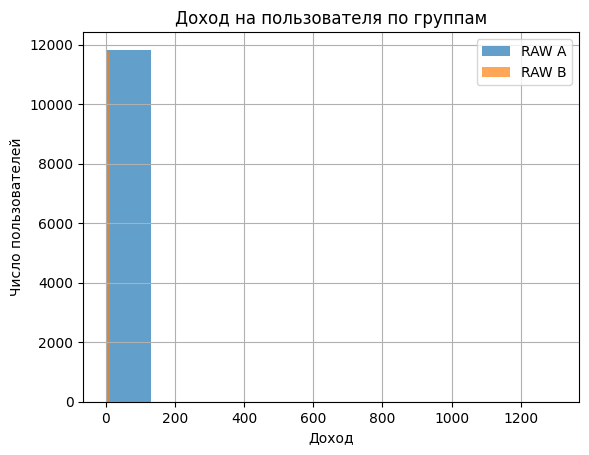

In [ ]:
raw_A.revenue.hist(bins = 10, alpha =0.7, label='RAW A')
raw_B.revenue.hist(bins = 10, alpha =0.7, label='RAW B')
plt.title('Доход на пользователя по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

Построим гистограмму распределения выручки между группами A и B в наборе - unic

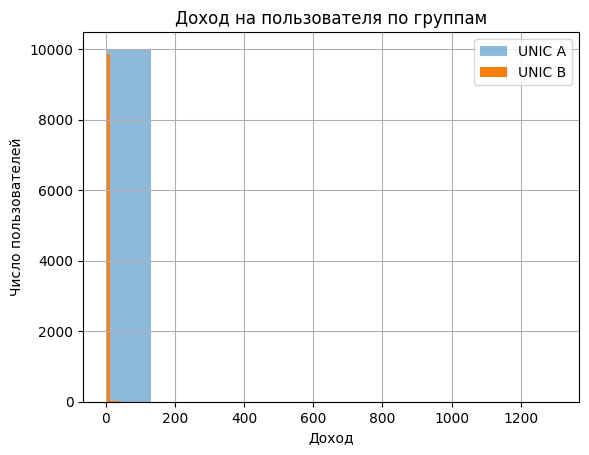

In [ ]:
unic_A.revenue.hist(bins = 10, alpha =0.5, label='UNIC A')
unic_B.revenue.hist(bins = 10, alpha =1, label='UNIC B')
plt.title('Доход на пользователя по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

Построим boxplot для всех наборов данных: raw и unic

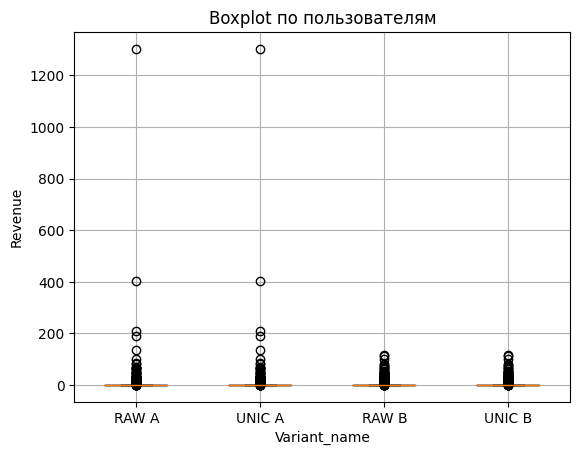

In [ ]:
plt.boxplot([raw_A.revenue, unic_A.revenue, raw_B.revenue, unic_B.revenue],
            labels=['RAW A', 'UNIC A', 'RAW B', 'UNIC B'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.xlabel('Variant_name')
plt.ylabel('Revenue')
plt.grid(axis  ='both')

**Вывод_2.3:** Как видно из графиков особой разницы между распределением в исходном наборе данных raw и в очищенном наборе unic нет. В обоих наборах данных много выбросов

Определим есть ли статистически значимая разница в наборах raw и unic, используем критерий Манна-Уитни.

In [ ]:
alpha = 0.05
mw1 = mannwhitneyu(x=raw_A.revenue.values,
                  y=raw_B.revenue.values)
mw1

MannwhitneyuResult(statistic=70054756.0, pvalue=0.3243889561742552)

In [ ]:
alpha = 0.05
mw2 = mannwhitneyu(x=unic_A.revenue.values,
                  y=unic_B.revenue.values)
mw2


MannwhitneyuResult(statistic=49697489.5, pvalue=0.34836759555848285)

**Вывод_2.4:** В результате расчета статистической разницы между наборами данных,используя метод расчета критерия Манна-Уитни, получили следующие результаты: p-value больше уровня значимости  α=0.05, следовательно, статистически значимой разницы в наборах данных raw и unic нет.

Выполним двухвыборочную t-проверку с помощью функции ttest_ind

In [ ]:
ttest_ind(raw_A.revenue.values, raw_B.revenue.values, equal_var = False)

TtestResult(statistic=1.2854813731628816, pvalue=0.19864664657596015, df=13215.90224782156)

In [ ]:
ttest_ind(unic_A.revenue.values, unic_B.revenue.values, equal_var = False)

TtestResult(statistic=1.2766102943161395, pvalue=0.20176642122761151, df=11163.29429704626)

**Вывод_2.5:** В результате двухвыборочной t - проверки с помощью функции ttest_ind, p-value больше уровня значимости  α=0.05, а следовательно, статистически значимой разницы в наборах данных raw и unic нет.




Определим достаточна ли была мощность выборок, чтобы анализировать результаты, используя следующие формулы:<br>
d = (M1 – M2) / S_pooled<br>
S_pooled = sqrt( (std1^2 + std2^2) /2 )


Расчет мощности для raw неочищенные (первоначальные) данные

In [ ]:
raw_A_mean = raw_A.revenue.values.mean()
raw_B_mean = raw_B.revenue.values.mean()
raw_A_std = raw_A.revenue.values.std()
raw_B_std = raw_B.revenue.values.std()
raw_Spooled = np.sqrt((raw_A_std**2 + raw_B_std **2)/ 2)
raw_effect=float((raw_A_mean - raw_B_mean) / raw_Spooled)
raw_n=len(raw_A.revenue)

alpha = 0.05
analysis = TTestIndPower()
raw_power_result = analysis.solve_power(raw_effect, power=None, nobs1=raw_n, ratio=1.0, alpha=alpha)
raw_effect, raw_power_result

(0.01671218693672142, 0.2506063665071001)

Расчет мощности для очищенных данные - unic

In [ ]:
unic_A_mean = unic_A.revenue.values.mean()
unic_B_mean = unic_B.revenue.values.mean()
unic_A_std = unic_A.revenue.values.std()
unic_B_std = unic_B.revenue.values.std()
unic_Spooled = np.sqrt((unic_A_std**2 + unic_B_std **2)/ 2)
unic_effect=float((unic_A_mean - unic_B_mean) / unic_Spooled)
unic_n=len(unic_A.revenue)

alpha = 0.05
analysis = TTestIndPower()
unic_power_result = analysis.solve_power(unic_effect, power=None, nobs1=unic_n, ratio=1.0, alpha=alpha)
unic_effect, unic_power_result

(0.018067813869734682, 0.24786333394580118)

**Вывод_2.7:** Мощности тестов составили: для исходного набора данных raw - 25.06% и для очищенного набора unic - 24.7%, что является достаточно низким значением.

**Вывод_основной:** Таким образом, на основании проведенных расчетов и сделанных выводах выше и  несмотря на то что ARPPU в группе A выше, чем в группе B, приходим к выводу, что эти различия не являются статистически значимыми.

**Рекомендации менеджеру:**
1. A/B тест следует откатить назад.
2. Рассчитать требуемый размер выборки и избегать преждевременной остановки теста.
2. Увеличить длительность теста и запустить его заново.

**Задание 3.** <br>
Мы хотим провести А/Б-тест для трех источников трафика. Нынешняя конверсия равна 5%, мы ожидаем прирост в 0,2%.
Уровень доверия 97% и уровень мощности 87%.
Всего на наш продукт заходит 40 000 пользователей в месяц.<br>


**Задание 3.1.** <br>
За сколько дней мы сможем протестировать гипотезу? И что вы можете посоветовать по результатам подсчета?<br>

**Решение:**<br>
Первоначально определим размер выборки на каждую группу тестирования, использую следующую формулу:

$$
n = \left( \frac{{Z_{\alpha/2} \cdot \sqrt{{2 \cdot p \cdot (1 - p)}} + Z_{\beta} \cdot \sqrt{{p_1 \cdot (1 - p_1) + p_2 \cdot (1 - p_2)}}}}{{p_2 - p_1}} \right)^2
$$

где:

- $n$ — размер выборки на каждую группу,
- $Z_{\alpha/2}$ — z-значение, соответствующее уровню доверия,
- $Z_{\beta}$ — z-значение, соответствующее мощности теста,
- $p$ — базовая конверсия,
- $p_1$ — старая конверсия (равна $p$),
- $p_2$ — новая конверсия (равна $p + \Delta p$), где $\Delta p$ — ожидаемое изменение конверсии.

In [ ]:
alpha = round((1-0.97),2) # уровень значимости
alpha

0.03

In [ ]:
Z_alpha_2 = round((stats.norm.ppf(1 - alpha / 2)),2) # z-значение, соответствующее уровню доверия
Z_alpha_2

2.17

In [ ]:
power = 0.87 # мощность теста

In [ ]:
Z_beta = round((stats.norm.ppf(power)),2) # z-значение, соответствующее мощности теста
Z_beta

1.13

In [ ]:
p = 0.05 # базовая конверсия
delta_p = 0.002 # ожидаемое изменение

In [ ]:
p1 = p # старая конверсия
print(f'p1 = {p1}')
p2 = round((p + delta_p),3) # новая конверсия
print(f'p2 ={p2}')

p1 = 0.05
p2 =0.052


Размер выборки на каждую группу:

In [ ]:
n_group = round((Z_alpha_2 * math.sqrt(2 * p * (1 - p)) + Z_beta * math.sqrt(p1 * (1 - p1) + p2 * (1 - p2)))**2 / ((p2 - p1)**2))
print(f'n_group = {n_group}')

n_group = 260307


Общий размер выборки:

In [ ]:
n_total = 3 * n_group
print(f'n_total = {n_total}')

n_total = 780921


Количество дней для проведения теста:

In [ ]:
users_per_month = 40000 # количество пользователей, заходящих на продукт в месяц
days = round((n_total / users_per_month)*30)
days

586

**Вывод_3.1:** В результате расчетов, получили следующий период тестирования: 586 дня - для тестирования гипотезы для трех источников трафика, что означает слишком долгий период тестирования, который может повлиять на достоверность и на результаты тестирования.<br>
**Рекомендации:**
1. Уменьшение размера выборки, за счет уменьшения уровня мощности теста или уровня доверия, которые позволят оптимизировать объем данных для достижения статистической значимости.
2. Пересмотреть объем аудитории на которой проводится аб тестирование.

**Задание 3.2.** <br>
Допустим в задаче нет проблемы с количеством посетителей на сайт, тогда подведите результаты тестирования, если у нас следующие результаты по количеству конверсии:
1. 25 000
2. 30 000
3. 32 000


In [ ]:
# Результаты тестирования по количеству конверсии для трех источников трафика (группы: А, В, С)
success_A_result_convers = 25000 # количество успехов (конверсий) в группе А по результатам тестирования
print(f'success_A_result_convers = {success_A_result_convers}')
success_B_result_convers = 30000 # количество успехов (конверсий) в группе B по результатам тестирования
print(f'success_B_result_convers = {success_B_result_convers}')
success_C_result_convers = 32000 # количество успехов (конверсий) в группе C по результатам тестирования
print(f'success_C_result_convers = {success_C_result_convers}')

success_A_result_convers = 25000
success_B_result_convers = 30000
success_C_result_convers = 32000


In [ ]:
print(f'n_group = {n_group}') # размер выборки на каждую группу
print(f'n_total = {n_total}') # общий размер выборки

n_group = 260307
n_total = 780921


In [ ]:
# Пропорции конверсий для каждой из групп трафика (группы: А, В, С):
prop_A_result_convers = round((success_A_result_convers /n_group), 3)
print(f'prop_A_result_convers = {prop_A_result_convers}')
prop_B_result_convers= round((success_B_result_convers /n_group), 3)
print(f'prop_B_result_convers = {prop_B_result_convers}')
prop_C_result_convers = round((success_C_result_convers /n_group), 3)
print(f'prop_C_result_convers = {prop_C_result_convers}')

prop_A_result_convers = 0.096
prop_B_result_convers = 0.115
prop_C_result_convers = 0.123


In [ ]:
# Выполним Z-тест для разности долей между группами:
# группы А и В
z_stat_AB, p_value_AB = proportions_ztest([success_A_result_convers, success_B_result_convers], [n_total, n_total])
print(f"Z-статистика_AB ={z_stat_AB:.2f}")
print(f"p-value_AB = {p_value_AB:.2f}")
# группы А и C
z_stat_AC, p_value_AC = proportions_ztest([success_A_result_convers, success_C_result_convers], [n_total, n_total])
print(f"Z-статистика_AC ={z_stat_AC:.2f}")
print(f"p-value_AC = {p_value_AC:.2f}")
# группы B и C
z_stat_BC, p_value_BC = proportions_ztest([success_B_result_convers, success_C_result_convers], [n_total, n_total])
print(f"Z-статистика_BC ={z_stat_BC:.2f}")
print(f"p-value_BC = {p_value_BC:.2f}")

Z-статистика_AB =-21.71
p-value_AB = 0.00
Z-статистика_AC =-29.87
p-value_AC = 0.00
Z-статистика_BC =-8.20
p-value_BC = 0.00


In [ ]:
# Выполним проверку статистической значимости для Z-теста:
alpha = round((1-0.97),2) # уровень значимости при уровне доверия 97 %
if p_value_AB < alpha:
    print("Отклоняем нулевую гипотезу. Существует статистически значимая разница в конверсии между группами AB.")
if p_value_AC < alpha:
    print("Отклоняем нулевую гипотезу. Существует статистически значимая разница в конверсии между группами AC.")
if p_value_BC < alpha:
    print("Отклоняем нулевую гипотезу. Существует статистически значимая разница в конверсии между группами BC.")
else:
    print("Не отклоняем нулевую гипотезу. Разница в конверсии между группами статистически не значима.")

Отклоняем нулевую гипотезу. Существует статистически значимая разница в конверсии между группами AB.
Отклоняем нулевую гипотезу. Существует статистически значимая разница в конверсии между группами AC.
Отклоняем нулевую гипотезу. Существует статистически значимая разница в конверсии между группами BC.


In [ ]:
# Определим лучший результат по конверсии между группами А, В, С:
success_result_convers = max(prop_A_result_convers, prop_B_result_convers, prop_C_result_convers)
print(f'success_C_result_convers = {success_result_convers:.1%}')

success_C_result_convers = 12.3%


**Вывод_3.2:**
В результате расчетов, получили следующие результаты:
1. Для каждого из заданных значений конверсии Z-статистика превышает критическое значение, соответствующее уровню доверия 97%, а следовательно мы можем отвергнуть нулевую гипотезу о равенстве конверсий между группами.
2. Лучший результат по конверсии между группами А, В, С достигнут в группе С и равен 12.3 %.


**Задание 4.** <br>
Вы решили сравнивать метрику СРА в двух группах. Размер выборки - 2350 элементов в каждой группе.
Для проверки нормальности распределения на выборке в 2350 наблюдений применили, критерий Шапиро-Уилка и получили p-value, равный 0.00002, alpha = 5%.
Какой бы вывод мы могли сделать в данном случае?
В этом случае какой статистический критерий для проверки первоначальной гипотезы тут лучше всего подойдёт и почему?


**Вывод:**<br>

Критерий Шапиро-Уилка позволяет оценить нормальность распределения данных. В нашем случае при проверки нормальности распределения данных на выборке в 2350 наблюдений в каждой из групп, получили p-value = 0.00002, что меньше уровня значимости alpha = 0.05. <br> Из чего можно сделать вывод, что нулевая гипотеза (Н0), о том что данные в выборке распределены нормально отклоняется.<br>
И в данном случае для проверки первоначальной гипотезы подойдет такой  статистический критерий как Критерий Манна-Уитни, который применяется для сравнения двух независимых выборок, когда данные в выборках не имеют нормального распределения, а также для проверки гипотезы о равенстве средних значений в двух группах.



**Задание 5.** <br>
Мы провели АБ-тест на увеличение average timespent per user. По итогам тестирования мы получили следующие данные. Является ли результат статистически значимым с уровнем доверия 80%? Какую версию мы выкатим на продакшн?<br>
A)	Средняя - 360, отклонение - 40, количество - 9802<br>
B)	Средняя - 352, отклонение - 58, количество - 9789


**Решение:**<br>


Для решения данной задачи, воспользуемся t-критерием Стьюдента, который применяется для сравнения средних значений двух независимых между собой выборок.
При условии, что распределение признаков в каждой выборке соответствует нормальному распределению и дисперсии признака в выборках равны. Примем данное предположение.

In [ ]:
mean_A = 360
std_dev_A = 40
n_A = 9802
mean_B = 352
std_dev_B = 58
n_B = 9789

In [ ]:
alpha = round((1-0.80),2) # уровень значимости
alpha

0.2

In [ ]:
std_error = round(math.sqrt(std_dev_A**2 / n_A + std_dev_B**2 / n_B),2) # расчет стандартной ошибки
std_error

0.71

In [ ]:
t = round((mean_A - mean_B) / std_error, 2) # расчет t-критерия
t

11.27

In [ ]:
df = n_A + n_B - 2 # расчет степеней свободы
df

19589

In [ ]:
p_value = (1 - stats.t.cdf(abs(t), df)) * 2 # расчет p-значения
p_value

0.0

In [ ]:
reject_null = p_value < alpha # отвергаем ли мы нулевую гипотезу?
reject_null

True

**Вывод:**<br>

По результатам расчета t-критерий = 11.24, p-value = 0, что меньше уровня значимости alpha = 0.2, следовательно нулевую гипотезу (Н0) о равенстве средних отклоняем. Это означает, что различия в среднем времени, проведенном пользователем, статистически значимы.
Версию A выкатим в продакшн, так как она имеет большее среднее значение времени -360, проведенного пользователем, по сравнению с версией B - 352.

**Задание 6.** <br>
Создайте техническую архитектуру проекта по аб тестированию продукта он-лайн кинотеатра с учетом кросс-девайс аналитики по следующей гипотезе:
Если договориться с банком о 99% кэшбэке на подписку первого месяца, то это повысит конверсию в подписку на 30%, благодаря упрощенному принятию решения со стороны пользователя.
На схеме необходимо отобразить:
1.	Управленческий процесс по договоренностям с внешними партнерами.
2. Архитектуру данных с указанием систем, из которых будем скачивать данные.
3. Внутрикомандное взаимодействие.


**Решение:**<br>

In [ ]:
from google.colab import files
from IPython.display import Image
Image("/content/drive/MyDrive/Схема Итоговое задание 2.png", width=600)